In [1]:
import math
import itertools
import string
import re
import numbers
import functools
import collections
import pathlib

import pandas as pd # pip install pandas
import xlsxwriter # pip install XlsxWriter
import matplotlib.pyplot as plt # pip install matplotlib
import numpy as np # pip install numpy
import scipy.stats # pip install scipy

# Globally relevant helper functions

In [2]:
__valid_file_name_chars = f"-_(){string.ascii_letters}{string.digits}"

def sanitize_file_name(file_name: str) -> str:
  file_name = file_name.translate({
    ord("ü"): 'ue', ord("Ü"): "Ue",
    ord("ö"): "oe", ord("Ö"): "Oe",
    ord("ä"): "ae", ord("Ä"): "Ae",
    ord("ß"): "ss", ord("ẞ"): "Ss",
  })

  file_name = ''.join((c if c in __valid_file_name_chars else "_") for c in file_name)
  file_name = re.sub("_+", "_", file_name)
  
  return file_name

In [3]:
def to_excel(df: pd.DataFrame, file_name: str, sheet_name: str = 'sheet'): # Taken from https://stackoverflow.com/a/57204530
  # Initialize ExcelWriter and set df as output
  writer = pd.ExcelWriter(file_name, engine='xlsxwriter') 
  df.to_excel(writer, sheet_name=sheet_name, index=False)

  # worksheet is an instance of Excel sheet named <sheet_name> - used for inserting the table
  worksheet = writer.sheets[sheet_name]
  # workbook is an instance of the whole book - used i.e. for cell format assignment 
  workbook = writer.book  

  header_cell_format = workbook.add_format()
  # header_cell_format.set_rotation(90)
  header_cell_format.set_align('center')
  header_cell_format.set_align('vcenter')

  # Create list of dicts for header names 
  # (columns property accepts {'header': value} as header name)
  col_names = [{'header': col_name} for col_name in df.columns]

  # Add table with coordinates: first row, first col, last row, last col; 
  # header names or formatting can be inserted into dict.
  worksheet.add_table(0, 0, df.shape[0], df.shape[1]-1, {
      'columns': col_names,
      # 'style' = option Format as table value and is case sensitive 
      # (look at the exact name into Excel)
      'style': 'Table Style Medium 2'
  })

  # # Applies Excel's AutoFit to header columns. Skip the loop if AutoFit is not needed.
  # for i, col in enumerate(col_names):
  #   # Apply header_cell_format to cell on [row:0, column:i] and write text value from col_names
  #   worksheet.write(0, i, col['header'], header_cell_format)

  # worksheet.autofit() # Available in newer version of xlsxwriter

  # Computing the visual width of a column header is difficult, see https://stackoverflow.com/questions/29463274
  column_title_lengths = [len(x) for x in df.columns]
  for i, length in enumerate(column_title_lengths):
    width = math.ceil(4 + length * 1.0) # Seems OK    
    worksheet.set_column(i, i, width)

  if df.columns[0] == 'File':
    worksheet.set_column(0, 0, 60) # width somewhat arbitrarily chosen

  # Write the Excel file to disc
  writer.close()

In [4]:
def contains_timeout(where: str | list | set) -> bool:
  timeout_error = 'timeout.error'

  if isinstance(where, str):
    return timeout_error in where
  elif isinstance(where, list) or isinstance(where, set):
    return any(timeout_error in s for s in where)
  else:
    assert False, f'Cannot handle argument `where` of type "{type(where)}" with value "{where}"'

In [5]:
def contains_timeout_or_is_inconsistent(row: pd.DataFrame, verifier: str) -> bool:
  result = contains_timeout(row[f'Results:{verifier}']) or row[f'Consistent:{verifier}'] == False

  return result

In [6]:
def matches_expected_results(row, verifier: str, check_consistency: bool = True) -> bool:
  result = row[f'Results:{verifier}'] == row[f'ExpectedResults']

  if check_consistency:
    result = result and row[f'Consistent:{verifier}'] == True

  return result

In [7]:
def is_file_in_group(file_name: str, group_name: str):
  return group_name == 'All' or file_name.startswith(group_name + '/')

# Global definitions

In [8]:
benchmark_data_file_name = 'benchmark_data.csv'

# Verifiers and their startup times in millisecond.
# The names must match the column header prefixes in file `benchmark_data_file_name`.
# The startup times were measured on the hardware mentioned in the paper, and outside a virtual machine.
verifier_startup_times = {
  'SE-PS': 111, # previously "Greedy"
  'SE-PS-unopt': 111, # GreedyNoOpt
  'SE-PC': 112, # MCE
  'SE-TR': 124, # SilicarbonSimplify
  'VCG-TR': 421, # Carbicon
  'VCG-TA': 431, # Carbon
}

# Verifiers to consider during the analysis
verifiers = list(verifier_startup_times.keys())

# Our example groups. Must match the file name prefixes in file `benchmark_data_file_name`.
example_groups = [
  'All',
  'Ru1',
  'Ru2',
  'Go',
  'GoC',
  'RSL',
  'SC',
  'SCR',
  'PP',
  'Py',
  'PyP',
  'Rea',
  'Vi',
  'VeC',
  'VeV',
  'DaG',
  'DaV',
  'Vo',
  'Ru3',
]

# For experimenting: examples to exclude from the analysis
excluded_viper_files = [
  # 'VeC/vercors/publications/PrefixSum/StreamCompaction.cu.vpr',
  # 'VeC/vercors/publications/PrefixSum/Blelloch.cu.vpr',
  # 'VeC/vercors/publications/RedBlack/ListListQueue.java.vpr',
]

# Output directories
boxplots_directory = './boxplots'
excels_pairwise_verifiers_runtime = './runtime_excels'
excels_pairwise_verifiers_completeness = './completeness_excels'
excels_logging = './logging'

In [9]:
# Create output directories (if not yet existing)
for out_dir in [boxplots_directory, excels_pairwise_verifiers_runtime, excels_pairwise_verifiers_completeness, excels_logging]:
  pathlib.Path(out_dir).mkdir(parents=True, exist_ok=True)

# Read and preprocess benchmark data

In [10]:
sheet = pd.read_csv(benchmark_data_file_name, delimiter=',', skiprows=0, header='infer')
# display(sheet)
to_excel(sheet, f'{excels_logging}/initial_data.xlsx')
print(f'Read {sheet.shape[0]} rows')

sheet = sheet[~sheet.apply(lambda row: row['File'] in excluded_viper_files, axis=1)]
print(f'After removing {len(excluded_viper_files)} excluded files: {sheet.shape[0]} rows')

# NOTE: The next filter steps should not have any effects

sheet = sheet[sheet['File'].apply(type) == str] # Keep rows that have a file name
print(f'After removing rows with empty file names: {sheet.shape[0]} rows')

sheet = sheet[~sheet.duplicated(subset=['File'])]
print(f'After removing duplicated file rows: {sheet.shape[0]} rows')

sheet = sheet[~sheet.apply(lambda row: all([pd.isna(row[f'Result:{v}']) for v in verifiers]), axis=1)]
print(f'After removing rows with all-nan results: {sheet.shape[0]} rows')

sheet = sheet[~sheet.apply(lambda row: all([contains_timeout(str(row[f'Result:{v}'])) for v in verifiers]), axis=1)]
print(f'After removing rows with all-timeout results: {sheet.shape[0]} rows')

sheet = sheet[~sheet.apply(lambda row: all([row[f'Consistent:{v}'] == False for v in verifiers]), axis=1)]
print(f'After removing rows with all-inconsistent results: {sheet.shape[0]} rows')

Read 537 rows
After removing 0 excluded files: 537 rows
After removing rows with empty file names: 537 rows
After removing duplicated file rows: 537 rows
After removing rows with all-nan results: 537 rows
After removing rows with all-timeout results: 537 rows
After removing rows with all-inconsistent results: 537 rows


In [11]:
def split_verification_results(cell: object) -> list[str]:
  results = [r.strip() for r in str(cell).split(';')]
  assert(len(results)) > 0 # sanity check
  assert(len(results) == 1 if 'success' in results else True) # sanity check

  if results == ['success']:
    results = []

  results = sorted(results)

  return results

# NOTE: Must be the inverse of split_verification_results()
def unsplit_verification_results(results: list[str]) -> str:
  if results == []: return 'success'
  else: return ';'.join(results)

def create_results_columns_from_result_column(df: pd.DataFrame, verifier: str) -> pd.DataFrame:
  df[f'Results:{verifier}'] = df[f'Result:{verifier}'].map(split_verification_results)
  df[f'NoOfResults:{verifier}'] = df[f'Results:{verifier}'].map(len)

  return df

def subtract_startup_time(mean_cell: numbers.Number, verifier: str, verifier_startup_times: int) -> numbers.Number:
  min_startup_time = min(verifier_startup_times.values())

  try:
    mean = int(mean_cell)
    overhead = verifier_startup_times[verifier] - min_startup_time    
    return max(1, mean - overhead) # 1ms to avoid later divisions by zero
  except ValueError:
    return mean_cell

In [12]:
print('Adding columns "Results:V" and "NoOfResults:V" per verifier V')
for verifier in verifiers:
  sheet = create_results_columns_from_result_column(sheet, verifier)

print('\nSubtracting startup time from column "Mean:V" per verifier V')
for verifier in verifiers:
  startup_time = verifier_startup_times[verifier]
  sheet[f'Mean:{verifier}'] = sheet[f'Mean:{verifier}'].map(lambda cell: subtract_startup_time(cell, verifier, verifier_startup_times))

to_excel(sheet, f'{excels_logging}/preprocessed_data_01.xlsx')

Adding columns "Results:V" and "NoOfResults:V" per verifier V

Subtracting startup time from column "Mean:V" per verifier V


In [13]:
# TODO: A groupby might be faster (and more idiomatic)
print('\nExamples that are verified by all verifiers in at most T milliseconds:')
for ms in [1, 100, 250, 500, 1000, 2000, 3000, 5000]:
  df = sheet[sheet.apply(lambda row: all([row[f'Mean:{v}'] <= ms for v in verifiers]), axis=1)]
  print(f'  {df.shape[0]} / {round(df.shape[0] / sheet.shape[0] * 100, 2)}% <= {ms} ms')


Examples that are verified by all verifiers in at most T milliseconds:
  0 / 0.0% <= 1 ms
  0 / 0.0% <= 100 ms
  49 / 9.12% <= 250 ms
  112 / 20.86% <= 500 ms
  178 / 33.15% <= 1000 ms
  247 / 46.0% <= 2000 ms
  280 / 52.14% <= 3000 ms
  318 / 59.22% <= 5000 ms


In [14]:
assert(sheet.loc[sheet['ExpectedResult'] == 'unclear'].shape[0] == 0)
# sheet = sheet.loc[sheet['ExpectedResult'] != 'unclear'] # Keep rows for which the expected verification result is known
# print(f'\nAfter removing rows for which the expected verification result is unclear: {sheet.shape[0]} rows')

In [15]:
print('\nAdding columns "ExpectedResults" and "NoOfExpectedResults"')
sheet['ExpectedResults'] = sheet['ExpectedResult'].map(split_verification_results)
sheet['NoOfExpectedResults'] = sheet['ExpectedResults'].map(len)

# display(sheet)
to_excel(sheet, f'{excels_logging}/preprocessed_data_02_with_expected_verification_results.xlsx')


Adding columns "ExpectedResults" and "NoOfExpectedResults"


# Portfolio

## Identify portfolios

In [16]:
def powerset_except_empty(groundset: set[object]) -> collections.abc.Iterable[object]:
  for size in range(1, len(groundset) + 1):
    for subset in itertools.combinations(groundset, size):
      yield subset


_all_portfolio_files = frozenset(sheet['File'])
print(f'Considering {len(_all_portfolio_files)} files for portfolio computation')

# Will be populated with mappings from verifier to files that were consistently verified,
# with the expected result, by that particular verifier
portfolio_files_per_verifier = {}

print("Completeness-relevant data:")
for group_name in example_groups:
  print(group_name + ", ", end="")
print("\n", end="")
for group_name in example_groups:
  group_parts = [f for f in _all_portfolio_files if is_file_in_group(f, group_name)]
  print(f"{len(group_parts)}, ", end="")
print("\n", end="")

for verifier in verifiers:
  # Files that the current verifier successfully verified
  verified_df = sheet[sheet.apply(lambda row: matches_expected_results(row, verifier, check_consistency=True), axis=1)]
  portfolio_files_per_verifier[verifier] = frozenset(verified_df['File'])  

  # Remaining loop body: output additional completeness-relevant data
  print(verifier + ", ", end="")

  for group_name in example_groups:    
    group_parts = [f for f in _all_portfolio_files if is_file_in_group(f, group_name)]
    group_df = sheet.loc[sheet['File'].apply(lambda file_name : is_file_in_group(file_name, group_name))]
    group_df_pass = group_df[group_df.apply(lambda row: matches_expected_results(row, verifier, check_consistency=True), axis=1)]

    print(f"{len(group_parts) - len(group_df_pass)}, ", end="")
  print("\n", end="")

  for group_name in example_groups:
    group_parts = [f for f in _all_portfolio_files if is_file_in_group(f, group_name)]
    group_df = sheet.loc[sheet['File'].apply(lambda file_name : is_file_in_group(file_name, group_name))]
    group_df_fail = group_df[group_df.apply(lambda row: contains_timeout_or_is_inconsistent(row, verifier), axis=1)]

    print(f"{len(group_df_fail)}, ", end="")
  print("\n", end="")
  

portfolios = [] # Will be populated with verifier subsets
non_portfolios = [] # Will be populated with pairs (verifier subset, missed files)

print('\nComputing portfolios ...')
for verifier_subset in powerset_except_empty(verifiers):
  # print(f'  candidate subset {verifier_subset}')
  
  if any([frozenset(p).issubset(verifier_subset) for p in portfolios]):
    # print('    skipped since a subset already suffices')
    continue

  union_files_per_verifier = frozenset().union(*[portfolio_files_per_verifier[v] for v in verifier_subset])
  if (union_files_per_verifier == _all_portfolio_files):
    portfolios.append(verifier_subset)
  else:
    non_portfolios.append((verifier_subset, _all_portfolio_files - union_files_per_verifier))
  
non_portfolios = sorted(non_portfolios, key = lambda t: len(t[1]))

Considering 537 files for portfolio computation
Completeness-relevant data:
All, Ru1, Ru2, Go, GoC, RSL, SC, SCR, PP, Py, PyP, Rea, Vi, VeC, VeV, DaG, DaV, Vo, Ru3, 
537, 156, 11, 11, 17, 21, 8, 13, 38, 23, 18, 16, 46, 19, 5, 8, 41, 34, 52, 
SE-PS, 29, 0, 0, 2, 1, 4, 0, 0, 0, 2, 3, 15, 1, 0, 0, 0, 0, 1, 0, 
20, 0, 0, 1, 0, 3, 0, 0, 0, 2, 2, 10, 1, 0, 0, 0, 0, 1, 0, 
SE-PS-unopt, 59, 8, 0, 3, 4, 4, 0, 1, 0, 4, 3, 15, 3, 6, 2, 0, 0, 6, 0, 
19, 0, 0, 0, 0, 3, 0, 0, 0, 2, 1, 10, 2, 0, 0, 0, 0, 1, 0, 
SE-PC, 29, 1, 0, 0, 0, 4, 0, 0, 0, 3, 2, 15, 1, 2, 0, 0, 0, 1, 0, 
20, 1, 0, 0, 0, 3, 0, 0, 0, 1, 1, 10, 1, 2, 0, 0, 0, 1, 0, 
SE-TR, 40, 6, 5, 2, 3, 0, 0, 0, 0, 1, 2, 6, 2, 8, 1, 0, 0, 4, 0, 
20, 0, 5, 0, 3, 0, 0, 0, 0, 1, 0, 6, 0, 1, 0, 0, 0, 4, 0, 
VCG-TR, 47, 14, 6, 0, 5, 8, 0, 0, 0, 3, 1, 2, 2, 2, 1, 2, 0, 0, 1, 
20, 1, 6, 0, 2, 6, 0, 0, 0, 0, 1, 0, 2, 1, 0, 1, 0, 0, 0, 
VCG-TA, 74, 29, 7, 0, 6, 7, 0, 0, 0, 5, 1, 3, 4, 2, 0, 2, 0, 7, 1, 
42, 8, 7, 0, 5, 6, 0, 0, 0, 2, 1, 1, 3, 2, 0, 1, 0,

In [17]:
print(f'Found {len(portfolios)} portfolio(s)')
for portfolio in portfolios:
  print(portfolio)

print(f'\nFound {len(non_portfolios)} non-portfolio(s)')
for non_portfolio, missed_files in non_portfolios:  
  print(len(missed_files), non_portfolio)
  if len(missed_files) <= 5:
    for mf in missed_files: print(f'  {mf}')
  pd.DataFrame(missed_files).to_excel(f'{excels_logging}/non_portfolio---{len(missed_files)}---{sanitize_file_name(str(non_portfolio))}.xlsx')

print(f'\nPortfolios if we allowed missing at most T% examples')
for threshold in [0.001, 0.0025, 0.005, 0.01, 0.025, 0.05]:
  threshold_in_files = round(threshold * sheet.shape[0])
  print(f'  For T = {threshold * 100}% / {threshold_in_files} examples')
  for non_portfolio, missed_files in non_portfolios:
    if len(missed_files) <= threshold_in_files:
      print('   ', non_portfolio)

Found 1 portfolio(s)
('SE-PS', 'SE-TR', 'VCG-TR', 'VCG-TA')

Found 59 non-portfolio(s)
1 ('SE-PS', 'SE-TR', 'VCG-TR')
  PyP/nagini/sif_prob/testssif-probverificationexamplesno_obligationssecc-declassify.py.vpr
1 ('SE-PS', 'SE-TR', 'VCG-TA')
  Rea/reachability/examples/0_merge/0_mergeTree.vpr
1 ('SE-PS', 'SE-PS-unopt', 'SE-TR', 'VCG-TR')
  PyP/nagini/sif_prob/testssif-probverificationexamplesno_obligationssecc-declassify.py.vpr
1 ('SE-PS', 'SE-PS-unopt', 'SE-TR', 'VCG-TA')
  Rea/reachability/examples/0_merge/0_mergeTree.vpr
1 ('SE-PS', 'SE-PC', 'SE-TR', 'VCG-TR')
  PyP/nagini/sif_prob/testssif-probverificationexamplesno_obligationssecc-declassify.py.vpr
1 ('SE-PS', 'SE-PC', 'SE-TR', 'VCG-TA')
  Rea/reachability/examples/0_merge/0_mergeTree.vpr
1 ('SE-PS-unopt', 'SE-TR', 'VCG-TR', 'VCG-TA')
  VeC/vercors/publications/RedBlack/Tree.java.vpr
1 ('SE-PC', 'SE-TR', 'VCG-TR', 'VCG-TA')
  VeC/vercors/publications/RedBlack/Tree.java.vpr
1 ('SE-PS', 'SE-PS-unopt', 'SE-PC', 'SE-TR', 'VCG-TR')
  Py

## Add identified portfolios as verifiers

In [18]:
# Add found portfolios as additional verifiers.
# NOTE: Don't forget to add them (here) to any of the relevant (global) collections of verifiers (in particular, to `verifiers`)!

portfolio_verifiers = {} # Map of portfolio verifier name to included verifiers
manually_chosen_portfolios = {
  'P0': ('SE-PS', 'SE-TR', 'VCG-TR', 'VCG-TA'), 
  'P1': ('SE-PS', 'SE-TR', 'VCG-TR'), 
  'P2': ('SE-PS', 'VCG-TR'), 
  'P3': ('SE-PS', 'SE-TR')
}
all_portfolios = portfolios

for idx, portfolio in enumerate(all_portfolios):
  portfolio_name = f'Portf' + chr(ord('A') + idx)
  print(f'Verifier "{portfolio_name}" represents portfolio {portfolio}')

  portfolio_verifiers[portfolio_name] = portfolio
  verifiers.append(portfolio_name)
  ## verifier_startup_times <-- Should not be necessary to add portfolio to this dict since the latter shouldn't be used after this point

for portfolio_name, portfolio in manually_chosen_portfolios.items():
  print(f'Verifier "{portfolio_name}" represents portfolio {portfolio}')
  portfolio_verifiers[portfolio_name] = portfolio
  verifiers.append(portfolio_name)

Verifier "PortfA" represents portfolio ('SE-PS', 'SE-TR', 'VCG-TR', 'VCG-TA')
Verifier "P0" represents portfolio ('SE-PS', 'SE-TR', 'VCG-TR', 'VCG-TA')
Verifier "P1" represents portfolio ('SE-PS', 'SE-TR', 'VCG-TR')
Verifier "P2" represents portfolio ('SE-PS', 'VCG-TR')
Verifier "P3" represents portfolio ('SE-PS', 'SE-TR')


## Compute columns for portfolio verifiers

In [19]:
# Columns to compute: 'Consistent', 'Mean', 'Result', 'Results', 'NoOfResults'

def compute_portfolio_mean(row: pd.DataFrame, portfolio: list[str]) -> int:
  means = [
    row[f'Mean:{verifier}']
    for verifier in portfolio
    if matches_expected_results(row, verifier, check_consistency=True)
  ]

  return min(means)

def filter_non_portfolio(row: pd.DataFrame, portfolio: list[str]) -> bool:
  means = [
    row[f'Mean:{verifier}'] 
    for verifier in portfolio
    if matches_expected_results(row, verifier, check_consistency=True)
  ]
  
  return len(means) > 0

for portfolio_name in portfolio_verifiers:
  portfolio = portfolio_verifiers[portfolio_name]
  # print(portfolio_name, portfolio)

  print(f'Adding columns "Consistent:{portfolio_name}", "Result:{portfolio_name}", "Mean:{portfolio_name}"')
  sheet[f'Consistent:{portfolio_name}'] = True
  sheet[f'Result:{portfolio_name}'] = sheet['ExpectedResult']
  portfolio_df = sheet[sheet.apply(lambda row: filter_non_portfolio(row, portfolio), axis=1)]
  sheet[f'Mean:{portfolio_name}'] = portfolio_df.apply(lambda row: compute_portfolio_mean(row, portfolio), axis=1)

  print(f'Adding columns "Results:{portfolio_name}", "NoOfResults:{portfolio_name}"')
  sheet = create_results_columns_from_result_column(sheet, portfolio_name)

# display(sheet)
to_excel(sheet, f'{excels_logging}/preprocessed_data_03_with_portfolio_columns.xlsx')

Adding columns "Consistent:PortfA", "Result:PortfA", "Mean:PortfA"
Adding columns "Results:PortfA", "NoOfResults:PortfA"
Adding columns "Consistent:P0", "Result:P0", "Mean:P0"
Adding columns "Results:P0", "NoOfResults:P0"
Adding columns "Consistent:P1", "Result:P1", "Mean:P1"
Adding columns "Results:P1", "NoOfResults:P1"
Adding columns "Consistent:P2", "Result:P2", "Mean:P2"
Adding columns "Results:P2", "NoOfResults:P2"
Adding columns "Consistent:P3", "Result:P3", "Mean:P3"
Adding columns "Results:P3", "NoOfResults:P3"


# Computing pairwise comparisons (performance, completeness) between verifiers

In [20]:
_headers = [f'`Results:{v}`' for v in verifiers]
_query = f'not({" == ".join(_headers)})'
_mismatches = sheet.query(_query)

if not _mismatches.empty:
  print(f"Found {_mismatches.shape[0]} rows where at least two verifiers' results differ")
  # display(_mismatches)
  to_excel(_mismatches, f'{excels_logging}/different-verification-results.xlsx')

Found 125 rows where at least two verifiers' results differ


In [21]:
# Computes the relative percentage difference between two cell values:
# (V2-V1)/((V2+V1)/2) * 100, where V1 is the old value (baseline) and V2 the new value.
def relative_percent_difference(row: pd.DataFrame, baseline_col_header: str, new_col_header: str) -> float | str:
  baseline = str(row[baseline_col_header])
  new = str(row[new_col_header])

  result = None  
  if baseline == 'TO' or new == 'TO':
    assert(False) # Should never happen
  elif baseline == 'nan' or new == 'nan':
    result = 'nan'
  else:
    # print(baseline, new)
    n = int(float(new))
    b = int(float(baseline))
    result = round(((n - b) / ((n + b) / 2)) * 100, 2)

  assert(result != None)
  return result


print('Runtimes: verifier vs. verifier')

mean_rpd_column_headers = []

for [verifier1, verifier2] in itertools.combinations(verifiers, 2):
  print(' ', verifier1, 'vs.', verifier2)

  col_header = f'MeanRPD:{verifier1}->{verifier2}'
  mean_rpd_column_headers.append(col_header)

  sheet[col_header] = sheet.apply(lambda row: relative_percent_difference(row, f'Mean:{verifier1}', f'Mean:{verifier2}'), axis=1)


Runtimes: verifier vs. verifier
  SE-PS vs. SE-PS-unopt
  SE-PS vs. SE-PC
  SE-PS vs. SE-TR
  SE-PS vs. VCG-TR
  SE-PS vs. VCG-TA
  SE-PS vs. PortfA
  SE-PS vs. P0
  SE-PS vs. P1
  SE-PS vs. P2
  SE-PS vs. P3
  SE-PS-unopt vs. SE-PC
  SE-PS-unopt vs. SE-TR
  SE-PS-unopt vs. VCG-TR
  SE-PS-unopt vs. VCG-TA
  SE-PS-unopt vs. PortfA
  SE-PS-unopt vs. P0
  SE-PS-unopt vs. P1
  SE-PS-unopt vs. P2
  SE-PS-unopt vs. P3
  SE-PC vs. SE-TR
  SE-PC vs. VCG-TR
  SE-PC vs. VCG-TA
  SE-PC vs. PortfA
  SE-PC vs. P0
  SE-PC vs. P1
  SE-PC vs. P2
  SE-PC vs. P3
  SE-TR vs. VCG-TR
  SE-TR vs. VCG-TA
  SE-TR vs. PortfA
  SE-TR vs. P0
  SE-TR vs. P1
  SE-TR vs. P2
  SE-TR vs. P3
  VCG-TR vs. VCG-TA
  VCG-TR vs. PortfA
  VCG-TR vs. P0
  VCG-TR vs. P1
  VCG-TR vs. P2
  VCG-TR vs. P3
  VCG-TA vs. PortfA
  VCG-TA vs. P0
  VCG-TA vs. P1
  VCG-TA vs. P2
  VCG-TA vs. P3
  PortfA vs. P0
  PortfA vs. P1
  PortfA vs. P2
  PortfA vs. P3
  P0 vs. P1
  P0 vs. P2
  P0 vs. P3
  P1 vs. P2
  P1 vs. P3
  P2 vs. P3


/tmp/ipykernel_223971/729890480.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sheet[col_header] = sheet.apply(lambda row: relative_percent_difference(row, f'Mean:{verifier1}', f'Mean:{verifier2}'), axis=1)
/tmp/ipykernel_223971/729890480.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sheet[col_header] = sheet.apply(lambda row: relative_percent_difference(row, f'Mean:{verifier1}', f'Mean:{verifier2}'), axis=1)
/tmp/ipykernel_223971/729890480.py:32: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [22]:
# Given two cells that contain lists of verification results, this function counts the differences between the two lists.
# In various edge cases, the return value will be a string identifying the corresponding case.
def results_diff(row: pd.DataFrame, baseline_col_header: str, new_col_header: str) -> int | str:
  baseline = row[baseline_col_header]
  new = row[new_col_header]
  assert(isinstance(baseline, list))
  assert(isinstance(new, list))

  baseline = set(baseline)
  new = set(new)
  result = None

  if contains_timeout(baseline) and contains_timeout(new):
    result = '2x TO'
  elif contains_timeout(baseline):
    result = '-infinity'
  elif contains_timeout(new):
    result = '+infinity'
  elif baseline.issubset(new) or new.issubset(baseline):
    result = len(new) - len(baseline)
  else:
    result = 'nan'

  assert(result != None)
  return result


print('Completeness: verifier vs. verifier')

completeness_column_headers = []

for [verifier1, verifier2] in itertools.combinations(verifiers, 2):
  print(' ', verifier1, 'vs.', verifier2)

  col_header = f'NoOfResDiff:{verifier1}->{verifier2}'
  completeness_column_headers.append(col_header)

  sheet[col_header] = sheet.apply(lambda row: results_diff(row, f'Results:{verifier1}', f'Results:{verifier2}'), axis=1)

sheet = sheet.copy() # To defragment the sheet


Completeness: verifier vs. verifier
  SE-PS vs. SE-PS-unopt
  SE-PS vs. SE-PC
  SE-PS vs. SE-TR
  SE-PS vs. VCG-TR
  SE-PS vs. VCG-TA
  SE-PS vs. PortfA
  SE-PS vs. P0
  SE-PS vs. P1
  SE-PS vs. P2
  SE-PS vs. P3
  SE-PS-unopt vs. SE-PC
  SE-PS-unopt vs. SE-TR
  SE-PS-unopt vs. VCG-TR
  SE-PS-unopt vs. VCG-TA
  SE-PS-unopt vs. PortfA
  SE-PS-unopt vs. P0
  SE-PS-unopt vs. P1
  SE-PS-unopt vs. P2
  SE-PS-unopt vs. P3
  SE-PC vs. SE-TR
  SE-PC vs. VCG-TR
  SE-PC vs. VCG-TA
  SE-PC vs. PortfA
  SE-PC vs. P0
  SE-PC vs. P1
  SE-PC vs. P2
  SE-PC vs. P3
  SE-TR vs. VCG-TR
  SE-TR vs. VCG-TA
  SE-TR vs. PortfA
  SE-TR vs. P0
  SE-TR vs. P1
  SE-TR vs. P2
  SE-TR vs. P3
  VCG-TR vs. VCG-TA
  VCG-TR vs. PortfA


/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sheet[col_header] = sheet.apply(lambda row: results_diff(row, f'Results:{verifier1}', f'Results:{verifier2}'), axis=1)
/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sheet[col_header] = sheet.apply(lambda row: results_diff(row, f'Results:{verifier1}', f'Results:{verifier2}'), axis=1)
/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

  VCG-TR vs. P0
  VCG-TR vs. P1
  VCG-TR vs. P2
  VCG-TR vs. P3
  VCG-TA vs. PortfA
  VCG-TA vs. P0
  VCG-TA vs. P1
  VCG-TA vs. P2


/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sheet[col_header] = sheet.apply(lambda row: results_diff(row, f'Results:{verifier1}', f'Results:{verifier2}'), axis=1)
/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sheet[col_header] = sheet.apply(lambda row: results_diff(row, f'Results:{verifier1}', f'Results:{verifier2}'), axis=1)
/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

  VCG-TA vs. P3
  PortfA vs. P0
  PortfA vs. P1
  PortfA vs. P2
  PortfA vs. P3
  P0 vs. P1
  P0 vs. P2
  P0 vs. P3
  P1 vs. P2
  P1 vs. P3
  P2 vs. P3


/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sheet[col_header] = sheet.apply(lambda row: results_diff(row, f'Results:{verifier1}', f'Results:{verifier2}'), axis=1)
/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sheet[col_header] = sheet.apply(lambda row: results_diff(row, f'Results:{verifier1}', f'Results:{verifier2}'), axis=1)
/tmp/ipykernel_223971/1863537179.py:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

# Writing results to disc

In [23]:
to_excel(sheet, f'{excels_logging}/postprocessed_data.xlsx')

In [24]:
print('Runtimes: verifier vs. verifier')
print('A file row is included in a pairwise comparison if both verifiers')
print('  1. reported consistent results')
print('  2. agree on the reported results')
print('  3. reported a numerical mean runtime value (e.g. did not crash)\n')

for [verifier1, verifier2] in itertools.combinations(verifiers, 2):
  # print(verifier1, 'vs.', verifier2)

  vs_sheet = sheet.copy()

  # Preserve rows where both verifiers reported consistent results
  vs_sheet = vs_sheet[vs_sheet[f'Consistent:{verifier1}'] == True]
  vs_sheet = vs_sheet[vs_sheet[f'Consistent:{verifier2}'] == True]

  # Preserve rows where the two verifiers agree on their verification results
  vs_sheet = vs_sheet[vs_sheet[f'Result:{verifier1}'] == vs_sheet[f'Result:{verifier2}']]

  # Preserve rows where the two verifiers report an actual number
  vs_sheet = vs_sheet[vs_sheet[f'Mean:{verifier1}'].apply(lambda cell: isinstance(cell, numbers.Number))]
  vs_sheet = vs_sheet[vs_sheet[f'Mean:{verifier2}'].apply(lambda cell: isinstance(cell, numbers.Number))]
  
  print(f'  {verifier1} and {verifier2} agree on {vs_sheet.shape[0]} examples')

  # Keep only the relevant headers
  vs_sheet = vs_sheet[['File', f'MeanRPD:{verifier1}->{verifier2}', f'Mean:{verifier1}', f'Consistent:{verifier1}', f'Results:{verifier1}', f'Mean:{verifier2}', f'Consistent:{verifier2}', f'Results:{verifier2}']] # f'MeanPC:{verifier1}->{verifier2}'

  to_excel(vs_sheet, f'{excels_pairwise_verifiers_runtime}/{verifier1}-vs-{verifier2}-mean.xlsx')


Runtimes: verifier vs. verifier
A file row is included in a pairwise comparison if both verifiers
  1. reported consistent results
  2. agree on the reported results
  3. reported a numerical mean runtime value (e.g. did not crash)

  SE-PS and SE-PS-unopt agree on 497 examples
  SE-PS and SE-PC agree on 521 examples
  SE-PS and SE-TR agree on 483 examples
  SE-PS and VCG-TR agree on 468 examples
  SE-PS and VCG-TA agree on 446 examples
  SE-PS and PortfA agree on 508 examples
  SE-PS and P0 agree on 508 examples
  SE-PS and P1 agree on 508 examples
  SE-PS and P2 agree on 508 examples
  SE-PS and P3 agree on 508 examples
  SE-PS-unopt and SE-PC agree on 495 examples
  SE-PS-unopt and SE-TR agree on 461 examples
  SE-PS-unopt and VCG-TR agree on 442 examples
  SE-PS-unopt and VCG-TA agree on 424 examples
  SE-PS-unopt and PortfA agree on 478 examples
  SE-PS-unopt and P0 agree on 478 examples
  SE-PS-unopt and P1 agree on 478 examples
  SE-PS-unopt and P2 agree on 478 examples
  SE-PS-

In [25]:
print('Completeness: verifier vs. verifier')

for [verifier1, verifier2] in itertools.combinations(verifiers, 2):
  print(' ', verifier1, 'vs.', verifier2)

  vs_sheet = sheet.copy()

  # Keep rows where both verifiers reported consistent results
  vs_sheet = vs_sheet[vs_sheet[f'Consistent:{verifier1}'] == True]
  vs_sheet = vs_sheet[vs_sheet[f'Consistent:{verifier2}'] == True]

  # Keep relevant headers
  vs_sheet = vs_sheet[['File', f'NoOfResDiff:{verifier1}->{verifier2}', f'Mean:{verifier1}', f'Consistent:{verifier1}', f'Results:{verifier1}', f'NoOfResults:{verifier1}', f'Mean:{verifier2}', f'Consistent:{verifier2}', f'Results:{verifier2}', f'NoOfResults:{verifier2}']]

  to_excel(vs_sheet, f'{excels_pairwise_verifiers_completeness}/{verifier1}-vs-{verifier2}-completeness.xlsx')


Completeness: verifier vs. verifier
  SE-PS vs. SE-PS-unopt
  SE-PS vs. SE-PC
  SE-PS vs. SE-TR
  SE-PS vs. VCG-TR
  SE-PS vs. VCG-TA
  SE-PS vs. PortfA
  SE-PS vs. P0
  SE-PS vs. P1
  SE-PS vs. P2
  SE-PS vs. P3
  SE-PS-unopt vs. SE-PC
  SE-PS-unopt vs. SE-TR
  SE-PS-unopt vs. VCG-TR
  SE-PS-unopt vs. VCG-TA
  SE-PS-unopt vs. PortfA
  SE-PS-unopt vs. P0
  SE-PS-unopt vs. P1
  SE-PS-unopt vs. P2
  SE-PS-unopt vs. P3
  SE-PC vs. SE-TR
  SE-PC vs. VCG-TR
  SE-PC vs. VCG-TA
  SE-PC vs. PortfA
  SE-PC vs. P0
  SE-PC vs. P1
  SE-PC vs. P2
  SE-PC vs. P3
  SE-TR vs. VCG-TR
  SE-TR vs. VCG-TA
  SE-TR vs. PortfA
  SE-TR vs. P0
  SE-TR vs. P1
  SE-TR vs. P2
  SE-TR vs. P3
  VCG-TR vs. VCG-TA
  VCG-TR vs. PortfA
  VCG-TR vs. P0
  VCG-TR vs. P1
  VCG-TR vs. P2
  VCG-TR vs. P3
  VCG-TA vs. PortfA
  VCG-TA vs. P0
  VCG-TA vs. P1
  VCG-TA vs. P2
  VCG-TA vs. P3
  PortfA vs. P0
  PortfA vs. P1
  PortfA vs. P2
  PortfA vs. P3
  P0 vs. P1
  P0 vs. P2
  P0 vs. P3
  P1 vs. P2
  P1 vs. P3
  P2 vs. P3


# Grouping, Boxplots

## Background definitions

In [26]:
def convert_mean_rpd_column_to_float(df: pd.DataFrame, column_header: str) -> pd.DataFrame:
  df = df.copy()

  df[column_header] = df[column_header].map(lambda cell: str(cell))

  # Drop rows with NaN
  df = df[df[column_header] != 'nan']

  # # Drop rows where cell column_header isn't numeric
  # df = df[df[column_header].apply(lambda cell: isinstance(cell, numbers.Number))]

  return df.astype({column_header: 'float'})

## Writing groups to disc

In [27]:
print('File groups:')
for group_name in example_groups:
  print(f'  {group_name}:', end='')

  group_df = sheet.loc[sheet['File'].apply(lambda file_name : is_file_in_group(file_name, group_name))]
  group_df = group_df['File']
  print(f' {group_df.shape[0]} files', end='')

  group_df_file_name = f'{excels_logging}/{sanitize_file_name(group_name)}_FILES.xlsx'  
  group_df.to_excel(group_df_file_name)
  print(f', written to {group_df_file_name}')

File groups:
  All: 537 files, written to ./logging/All_FILES.xlsx
  Ru1: 156 files, written to ./logging/Ru1_FILES.xlsx
  Ru2: 11 files, written to ./logging/Ru2_FILES.xlsx
  Go: 11 files, written to ./logging/Go_FILES.xlsx
  GoC: 17 files, written to ./logging/GoC_FILES.xlsx
  RSL: 21 files, written to ./logging/RSL_FILES.xlsx
  SC: 8 files, written to ./logging/SC_FILES.xlsx
  SCR: 13 files, written to ./logging/SCR_FILES.xlsx
  PP: 38 files, written to ./logging/PP_FILES.xlsx
  Py: 23 files, written to ./logging/Py_FILES.xlsx
  PyP: 18 files, written to ./logging/PyP_FILES.xlsx
  Rea: 16 files, written to ./logging/Rea_FILES.xlsx
  Vi: 46 files, written to ./logging/Vi_FILES.xlsx
  VeC: 19 files, written to ./logging/VeC_FILES.xlsx
  VeV: 5 files, written to ./logging/VeV_FILES.xlsx
  DaG: 8 files, written to ./logging/DaG_FILES.xlsx
  DaV: 41 files, written to ./logging/DaV_FILES.xlsx
  Vo: 34 files, written to ./logging/Vo_FILES.xlsx
  Ru3: 52 files, written to ./logging/Ru3_FILE

## Grouping

In [28]:
print('Creating data groups')

# _figsize = (15, 10) # width, height; in inches
# _filetype = 'pdf' # svg, png

example_groups_dfs = {} # Maps group names to group dataframes

for group_name in example_groups:
  print(' ', group_name)
  # group_prefixes = example_groups[group_name]

  group_df = sheet.loc[sheet['File'].apply(lambda file_name : is_file_in_group(file_name, group_name))]
  assert group_df.shape[0] > 0, f'Found no files for group {group_name}'

  group_df_file_name = f'{excels_logging}/GROUP---{sanitize_file_name(group_name)}---{sanitize_file_name(col_header)}.xlsx'
  to_excel(group_df, group_df_file_name)

  for col_header in mean_rpd_column_headers:
    group_df = convert_mean_rpd_column_to_float(group_df, col_header)

  example_groups_dfs[group_name] = group_df

  # fig, ax = plt.subplots(tight_layout=True, figsize=_figsize)
  # ax.boxplot(group_df[mean_rpd_column_headers], notch=False) # Notches?

  # # Add a horizontal grid to the plot, but make it very light in color
  # # so we can use it for reading data values but not be distracting
  # ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

  # ax.set(
  #   axisbelow=True, # Hide the grid behind plot objects
  #   title=f'{group_name}:MeanRPD',
  #   xlabel='Pairs of Verifier',
  #   ylabel='RPD',
  # )
  
  # ax.set_xticklabels([shorten_mean_rpd_column_name(c_h) for c_h in mean_rpd_column_headers], rotation=45, fontsize=8)

  # image_file_name = f'{sanitize_file_name(group_name)}---{sanitize_file_name(col_header)}.{_filetype}'
  # print(image_file_name)
  # fig.savefig(image_file_name)


Creating data groups
  All
  Ru1
  Ru2
  Go
  GoC
  RSL
  SC
  SCR
  PP
  Py
  PyP
  Rea
  Vi
  VeC
  VeV
  DaG
  DaV
  Vo
  Ru3


## Boxplot: Groups (x-axis) vs. MeanRPD (y-axis)

MeanRPD:SE-PS->SE-PS-unopt
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PS-_SE-PS-unopt.pdf
MeanRPD:SE-PS->SE-PC
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PS-_SE-PC.pdf
MeanRPD:SE-PS->SE-TR
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PS-_SE-TR.pdf
MeanRPD:SE-PS->VCG-TR
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PS-_VCG-TR.pdf
MeanRPD:SE-PS->VCG-TA
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PS-_VCG-TA.pdf
MeanRPD:SE-PS->PortfA
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PS-_PortfA.pdf
MeanRPD:SE-PS->P0
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PS-_P0.pdf
MeanRPD:SE-PS->P1
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./b

/tmp/ipykernel_223971/702984619.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(tight_layout=True, figsize=_figsize)


MeanRPD:SE-PC->VCG-TA
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PC-_VCG-TA.pdf
MeanRPD:SE-PC->PortfA
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PC-_PortfA.pdf
MeanRPD:SE-PC->P0
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PC-_P0.pdf
MeanRPD:SE-PC->P1
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PC-_P1.pdf
MeanRPD:SE-PC->P2
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PC-_P2.pdf
MeanRPD:SE-PC->P3
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-PC-_P3.pdf
MeanRPD:SE-TR->VCG-TR
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-TR-_VCG-TR.pdf
MeanRPD:SE-TR->VCG-TA
All Ru1 Ru2 Go GoC RSL SC SCR PP Py PyP Rea Vi VeC VeV DaG DaV Vo Ru3 
./boxplots/MeanRPD_SE-TR-_VCG

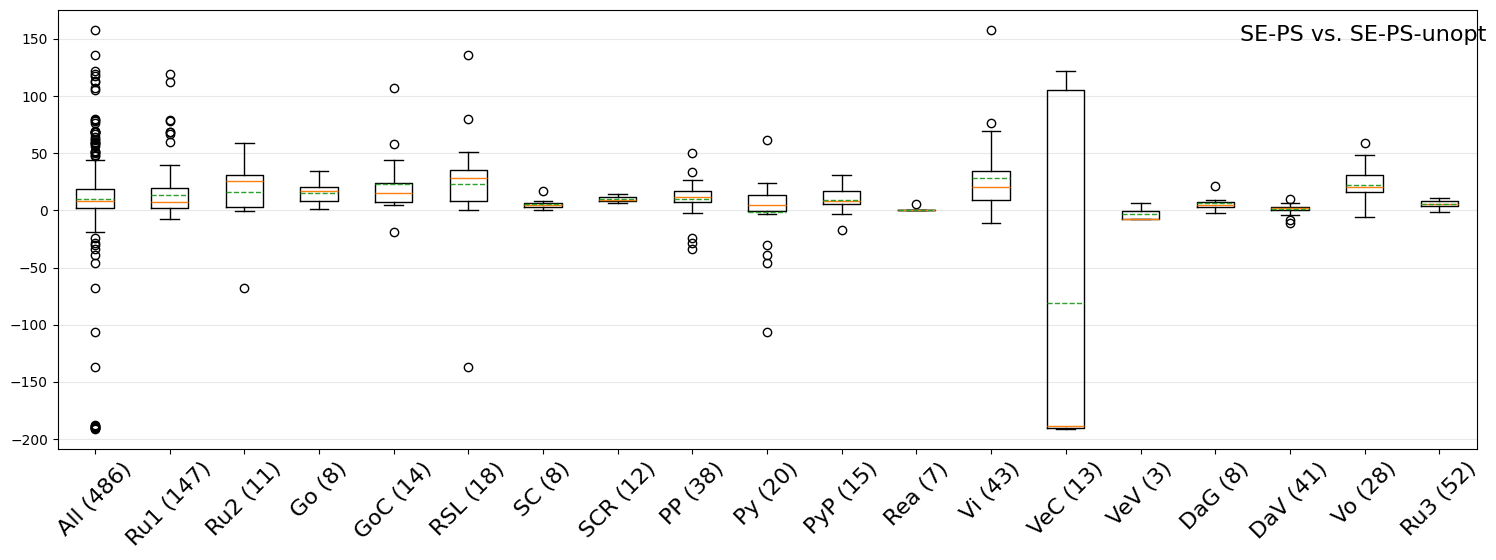

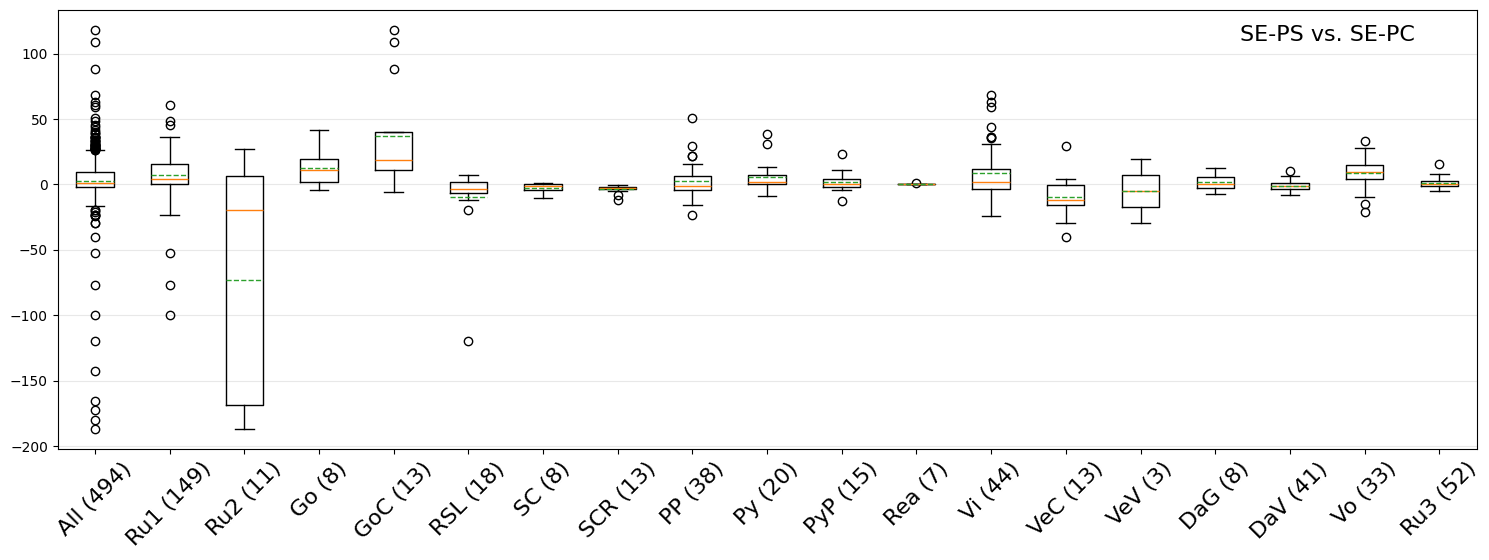

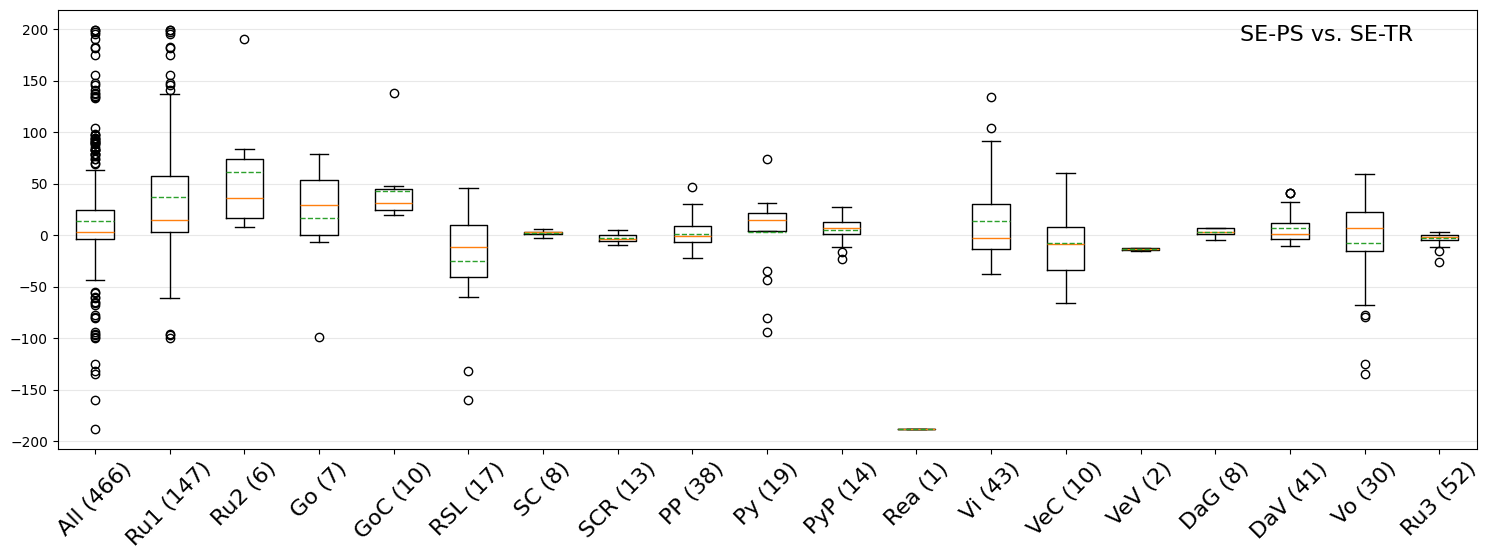

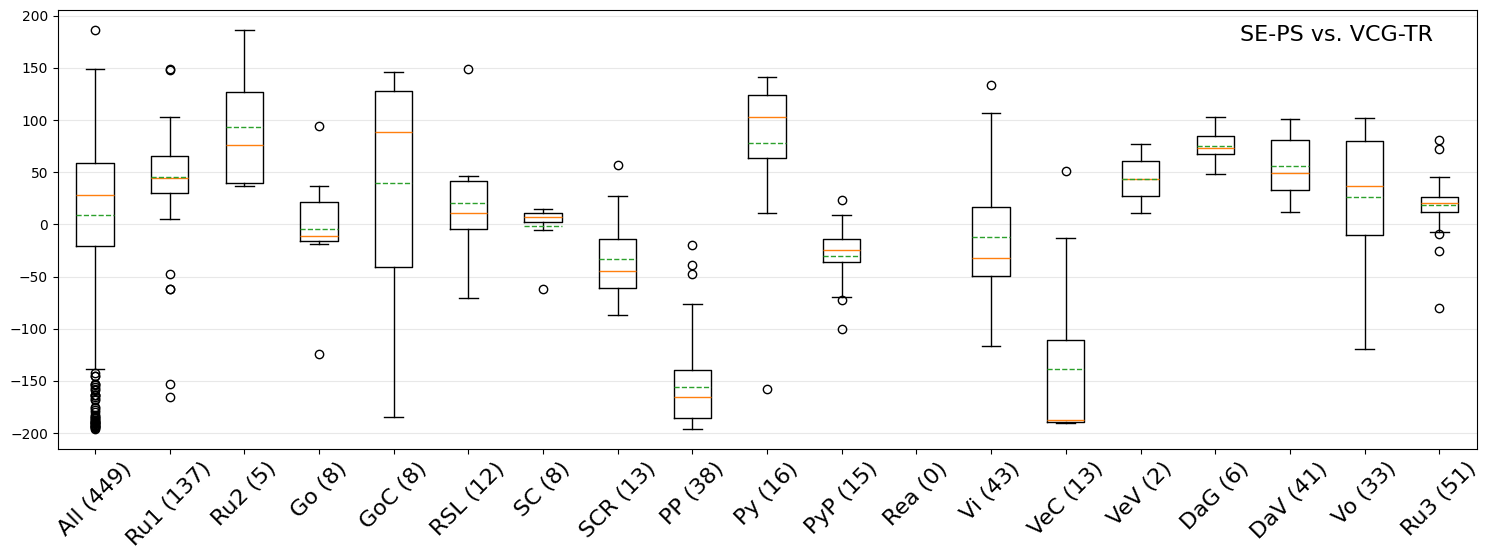

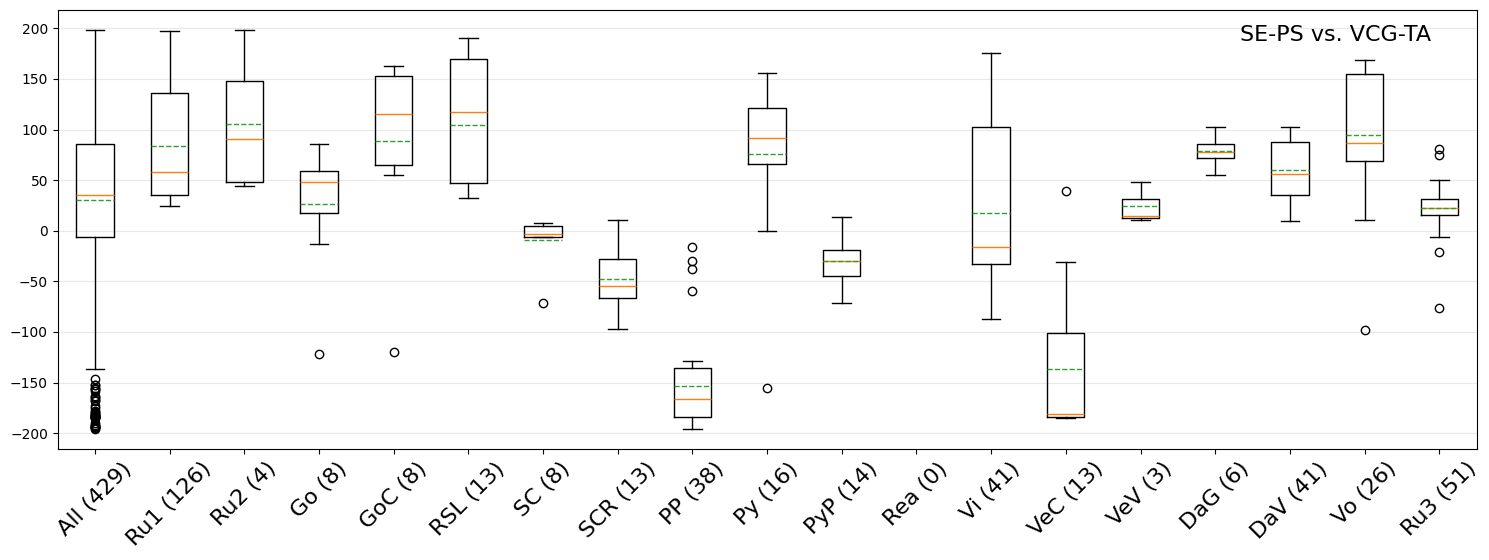

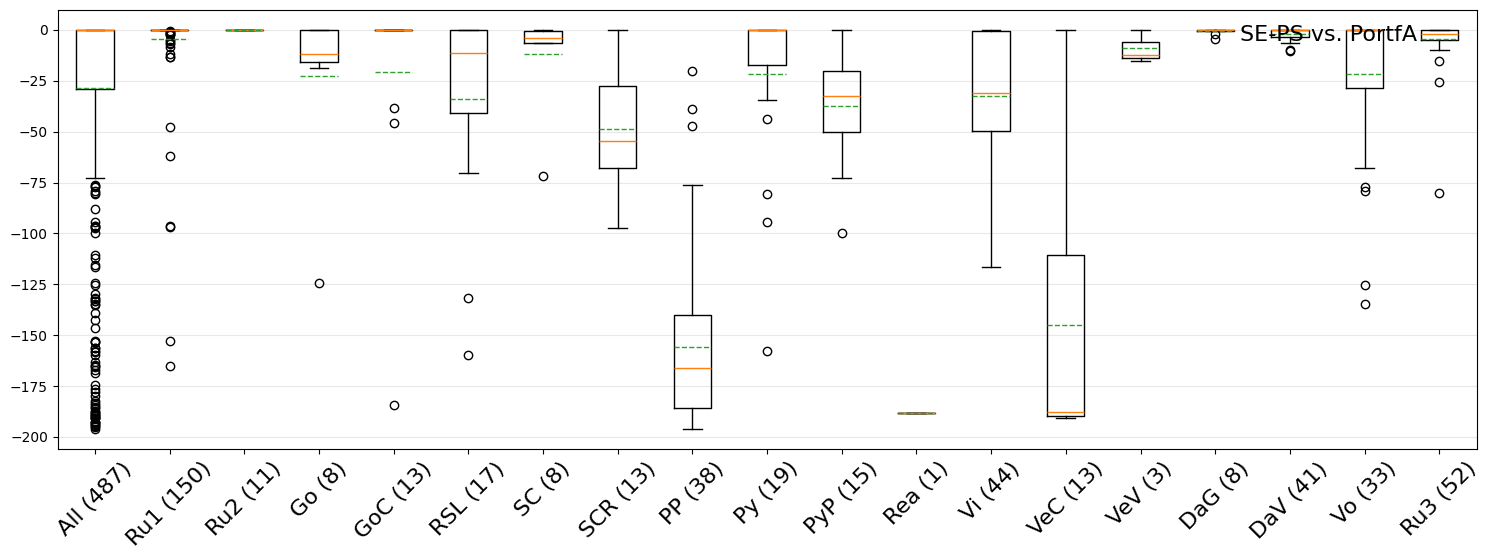

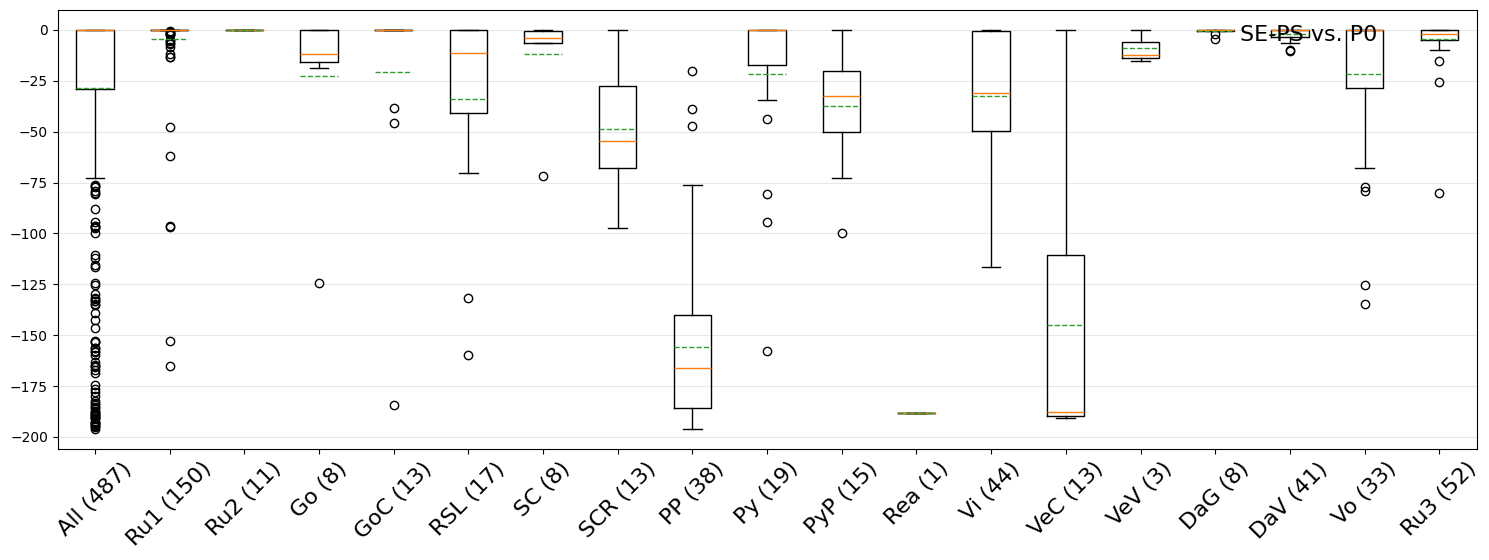

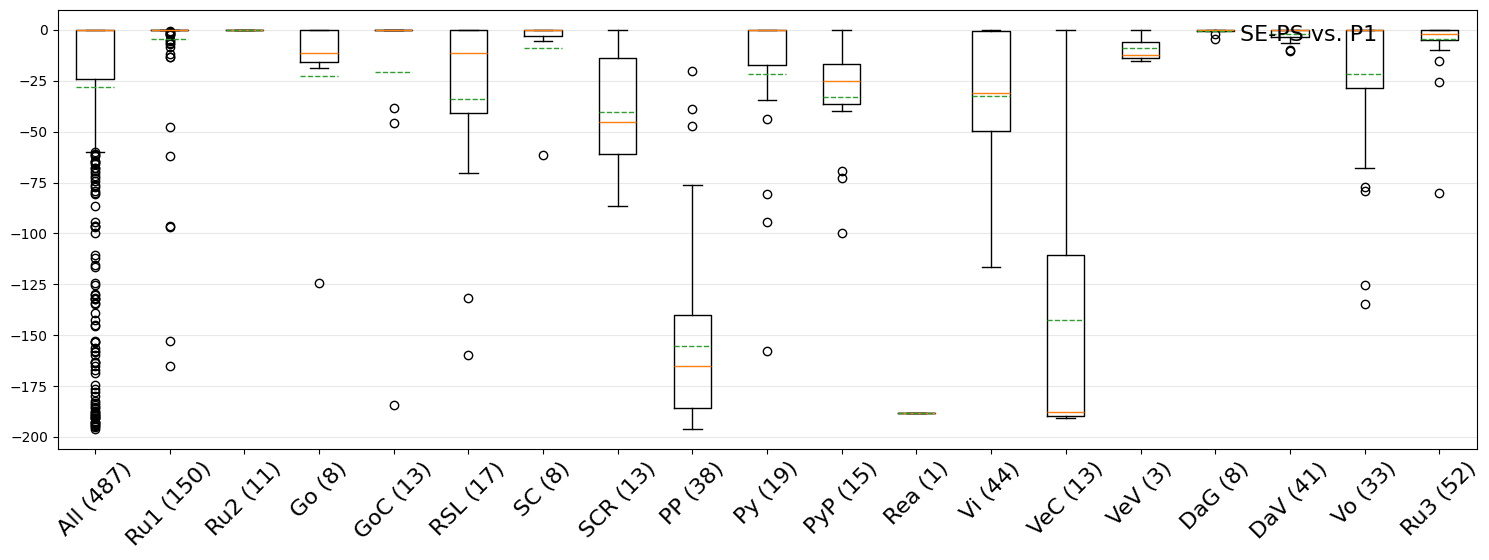

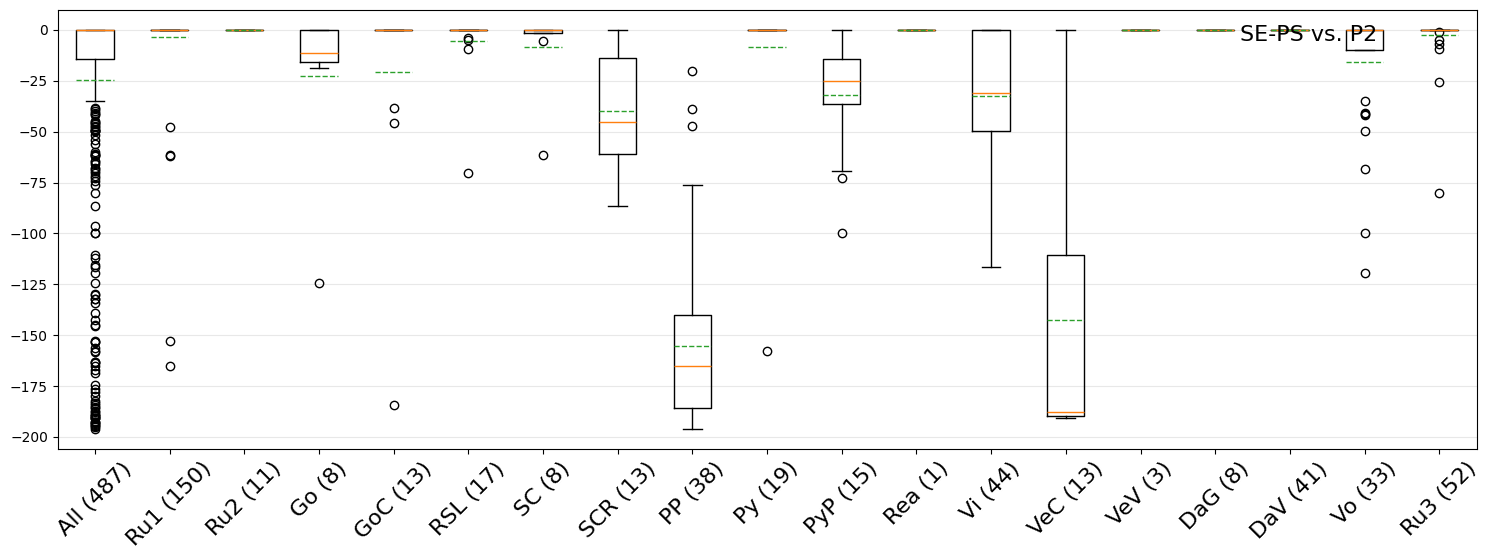

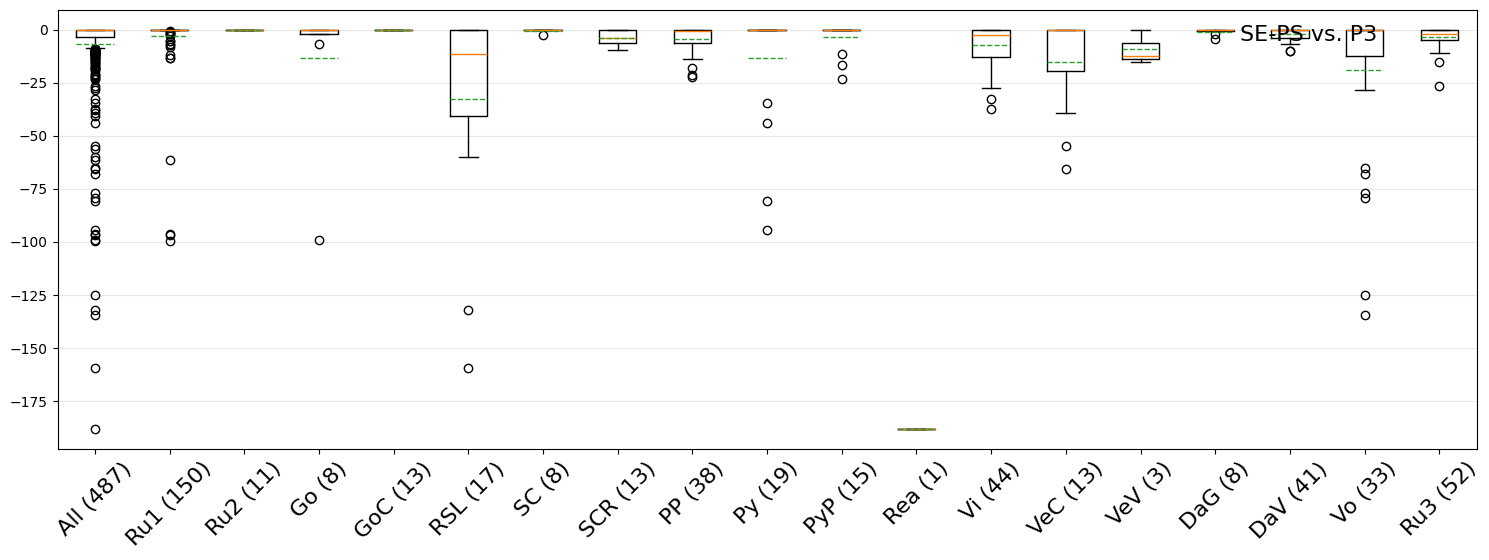

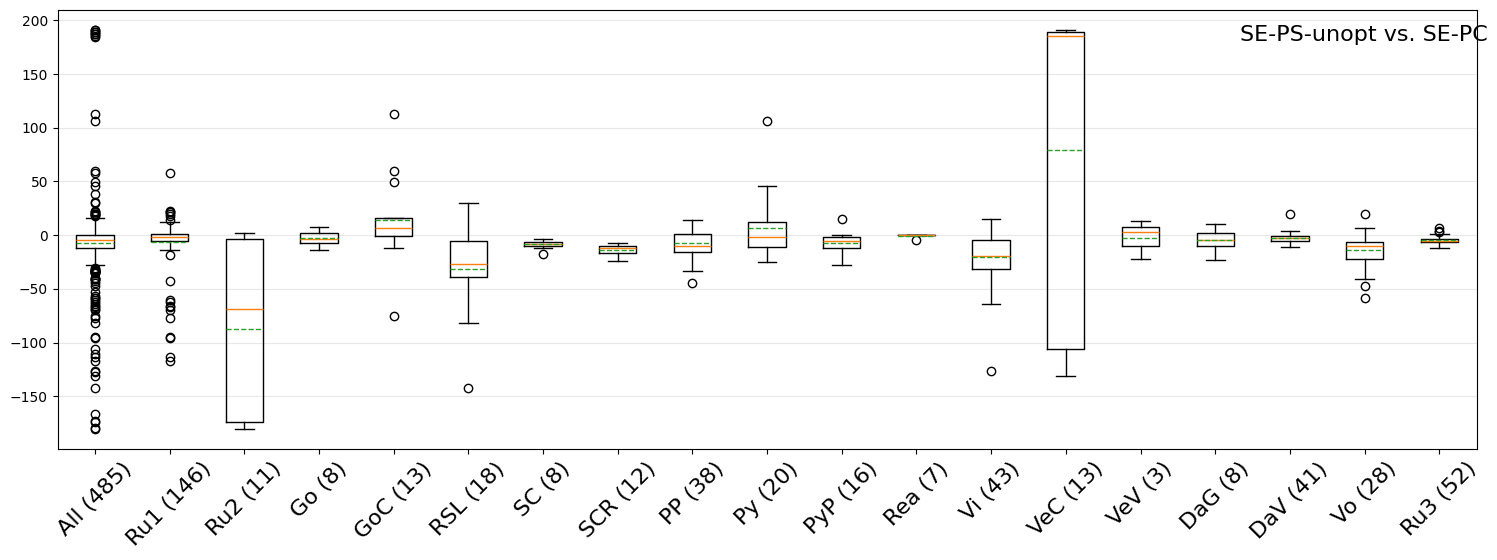

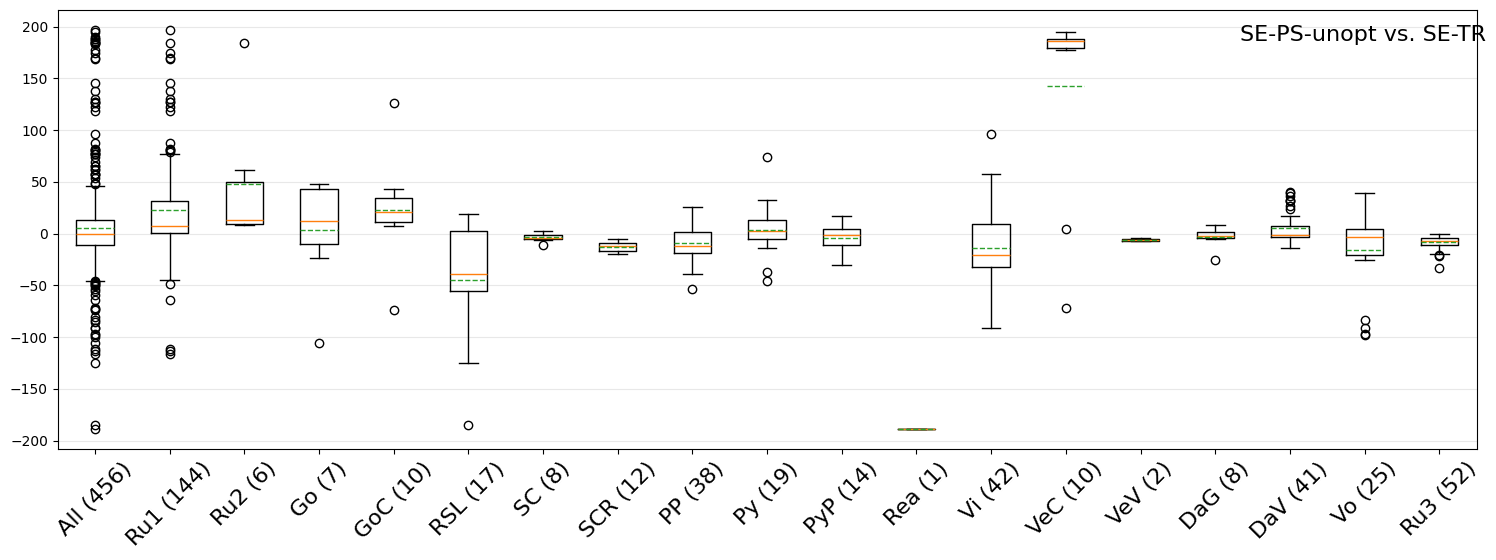

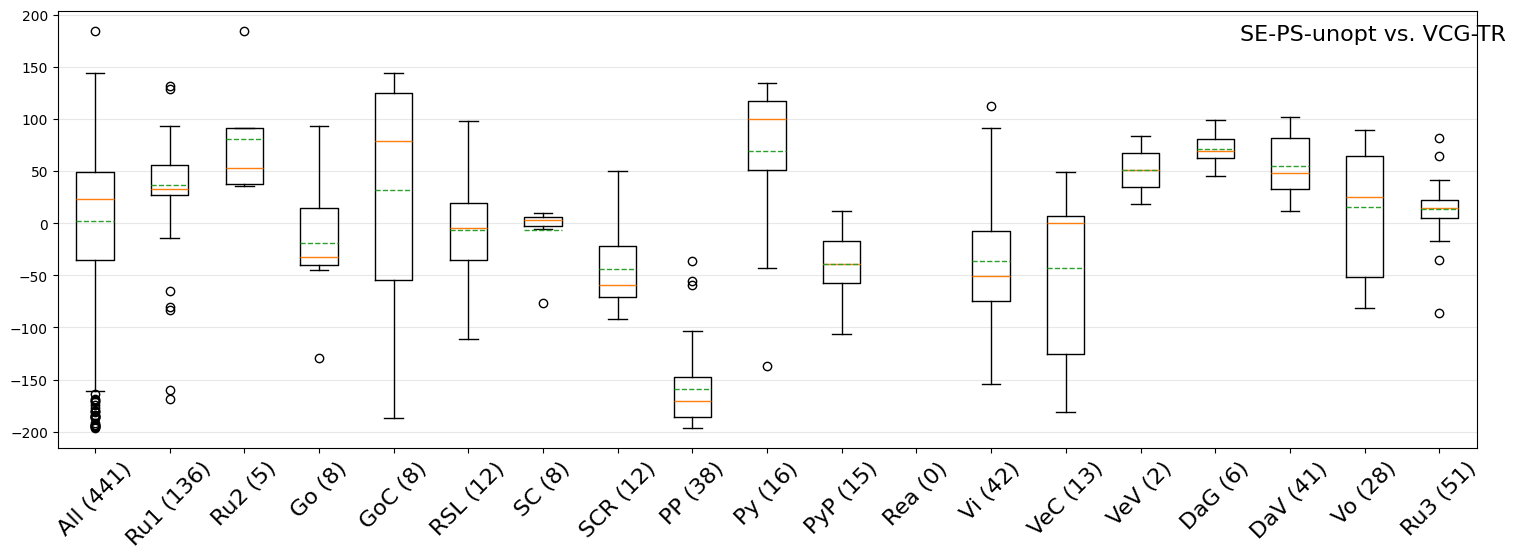

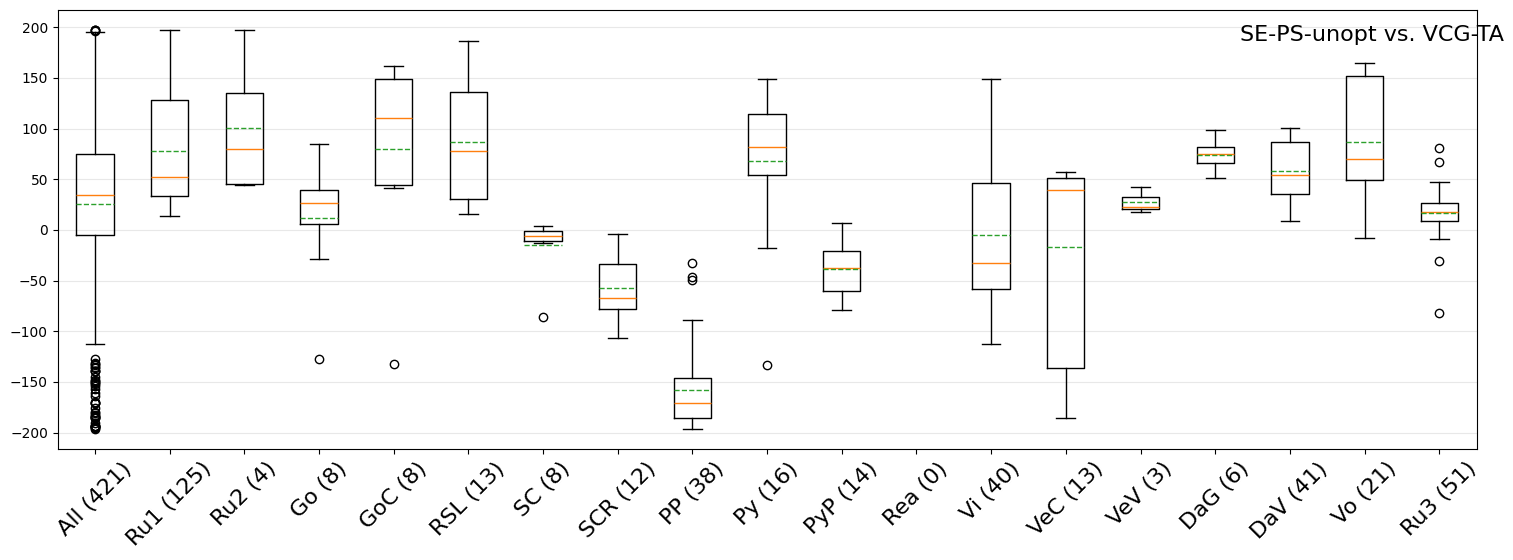

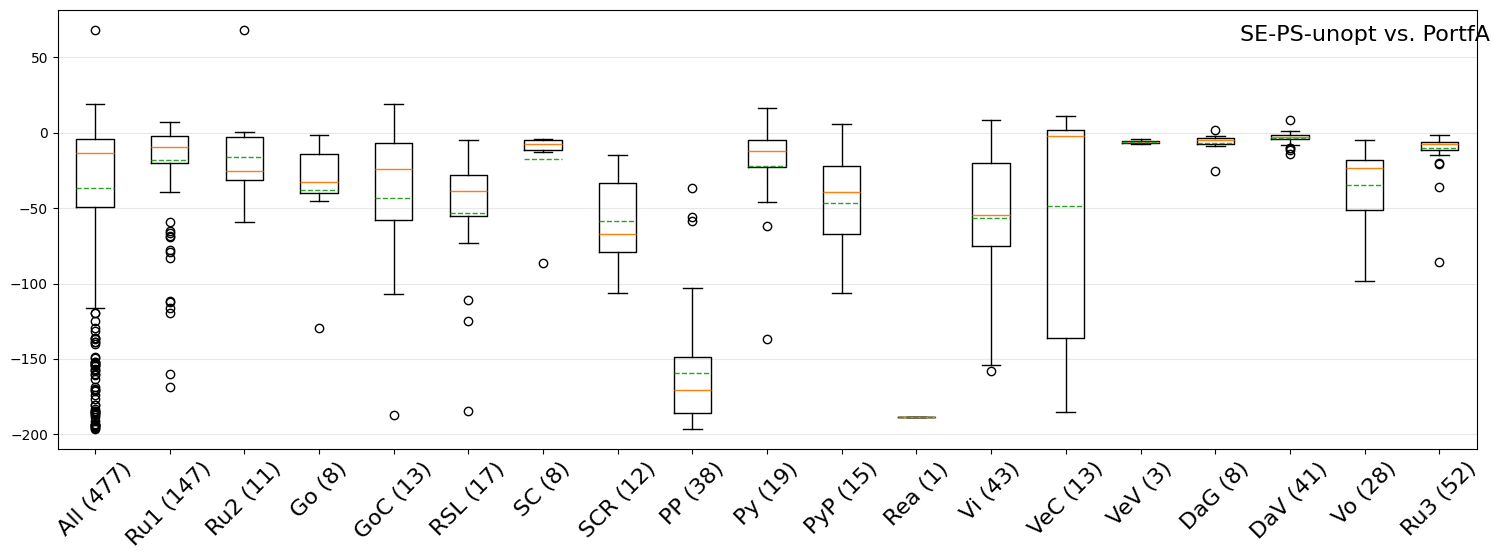

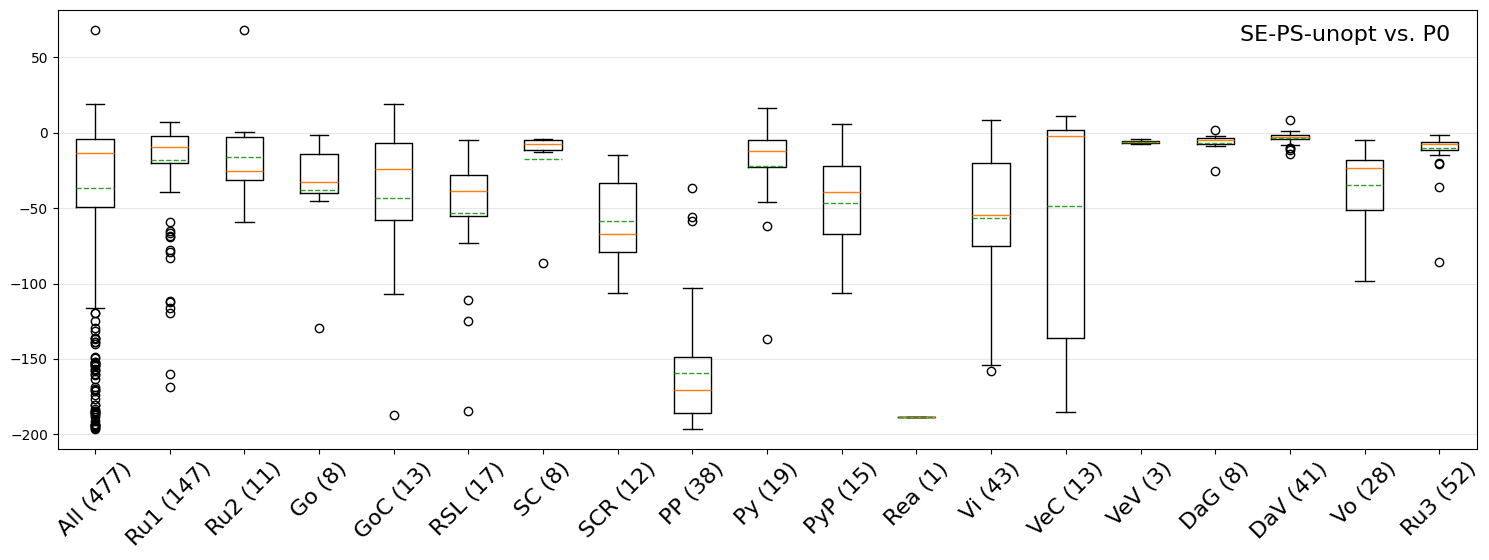

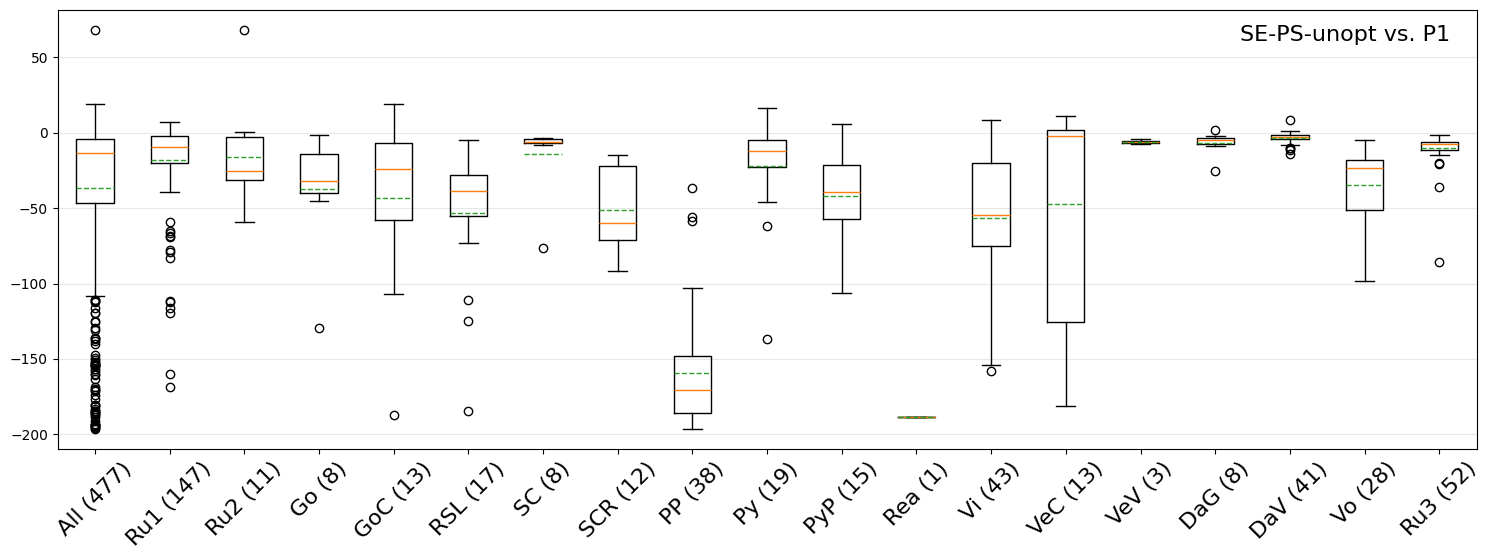

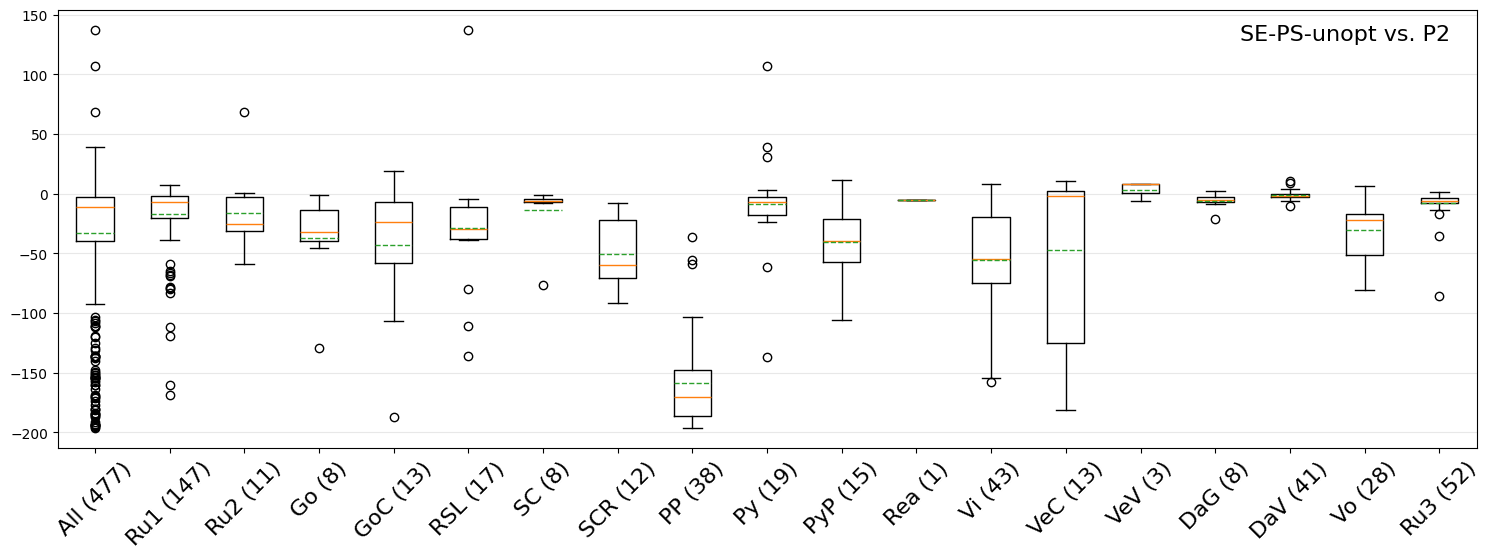

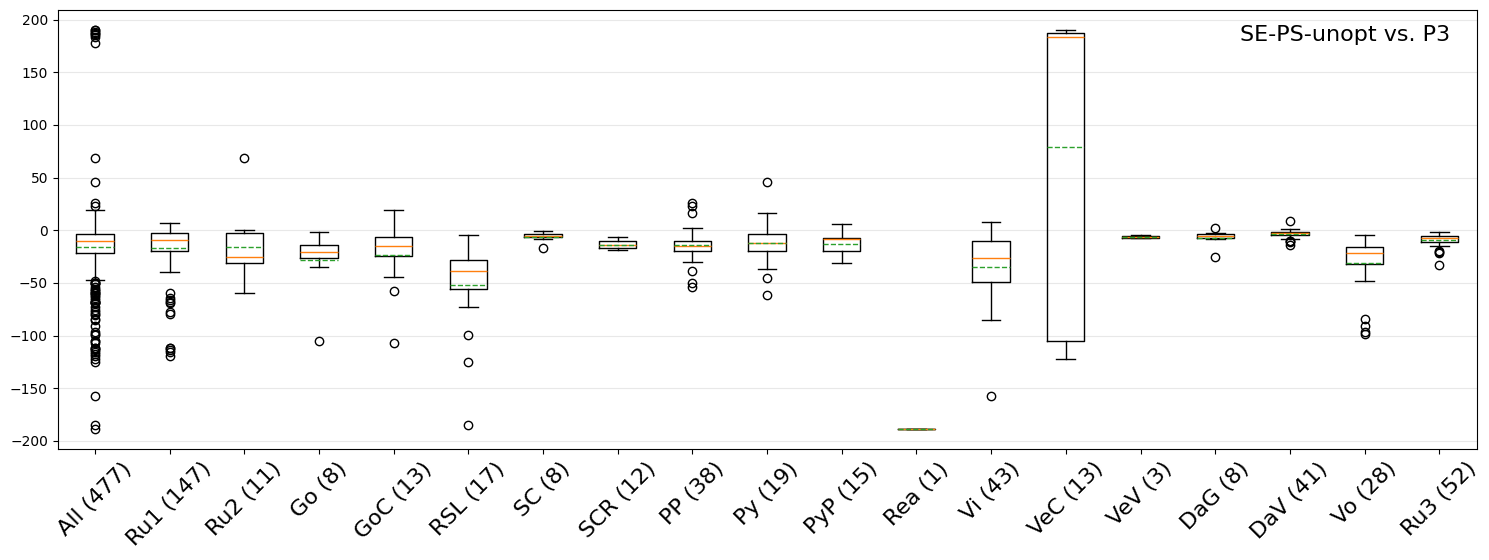

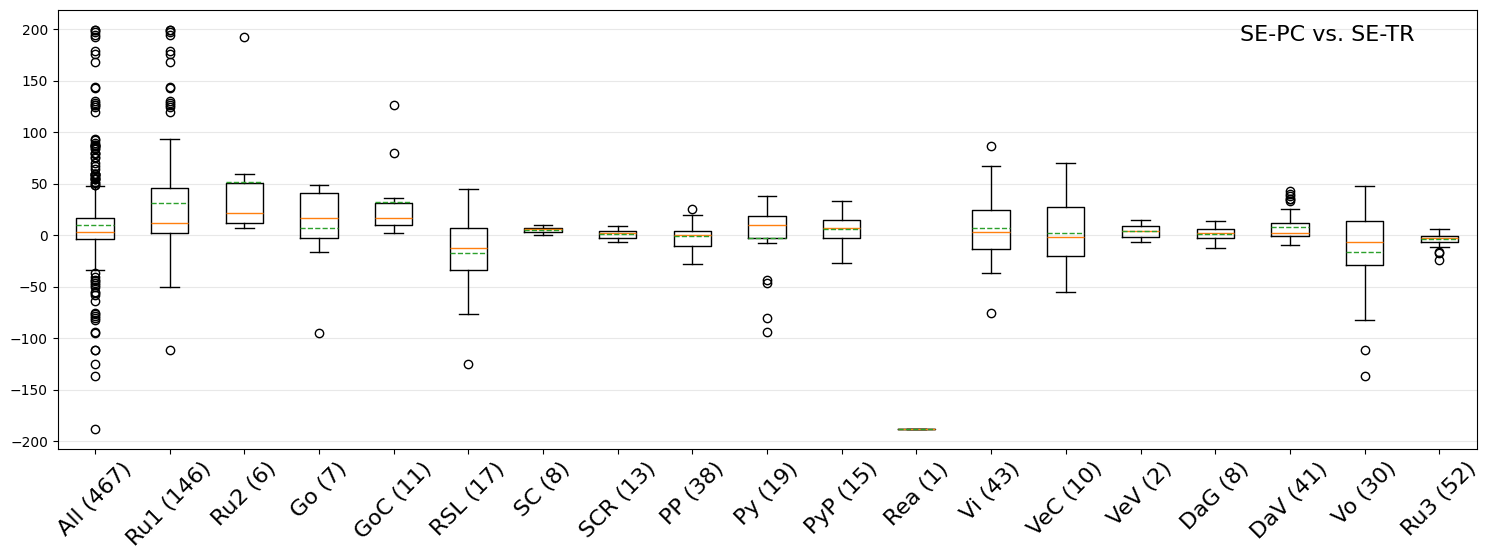

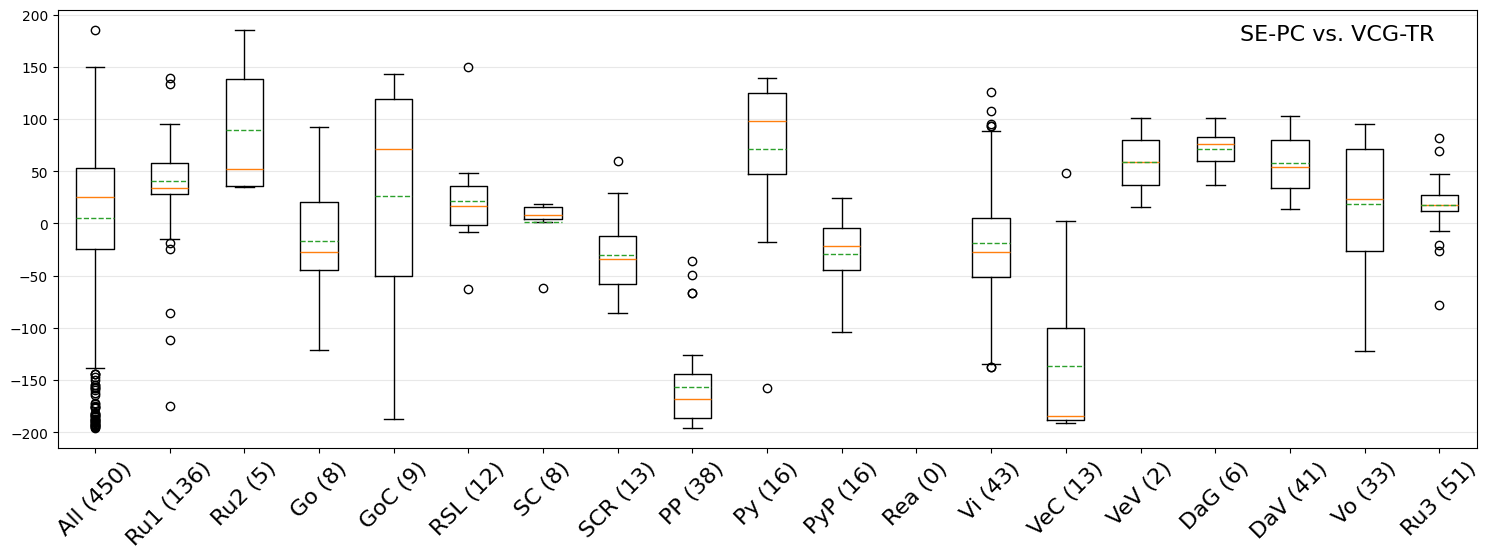

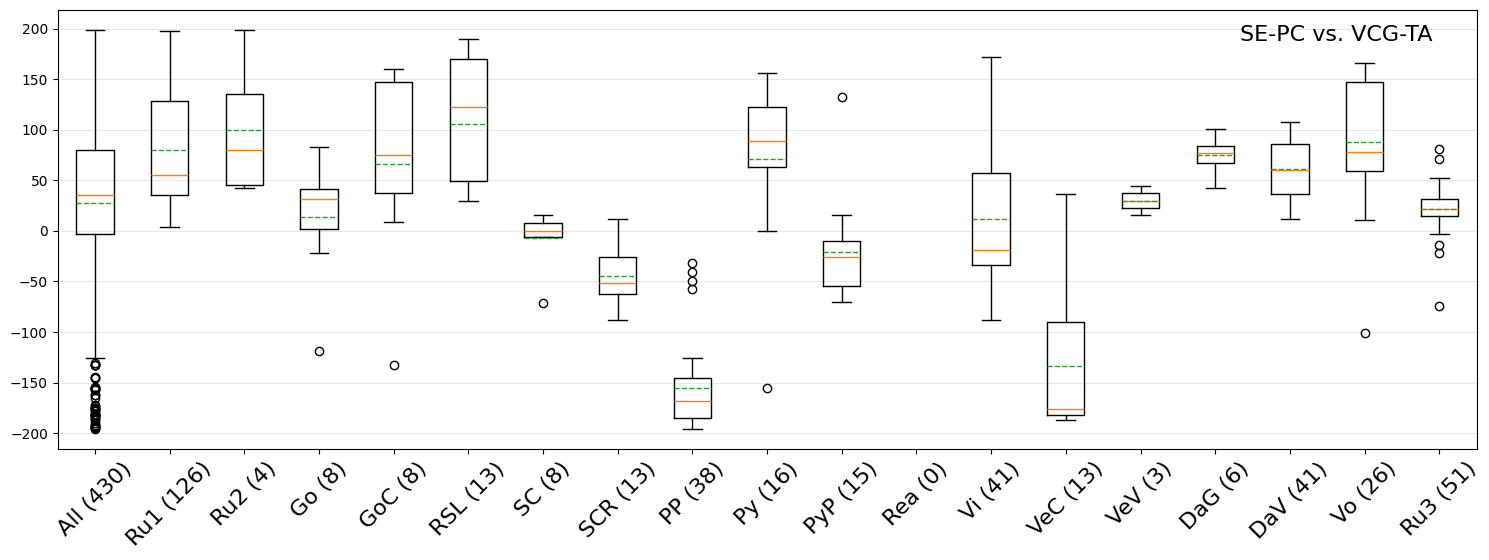

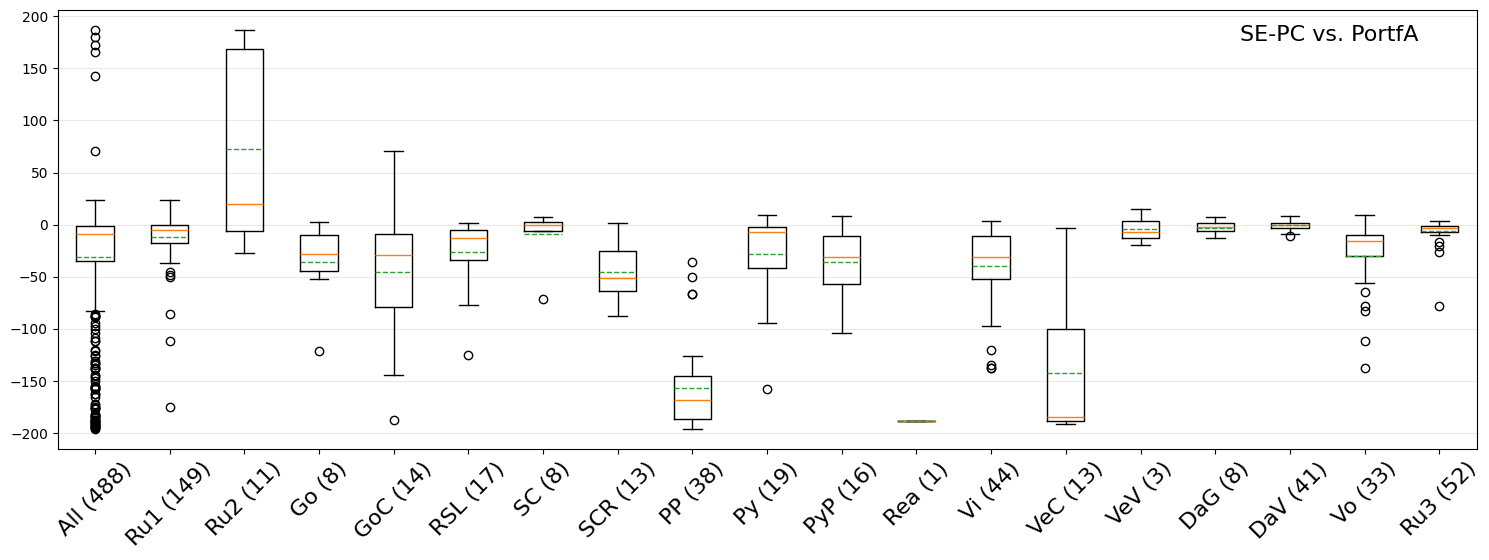

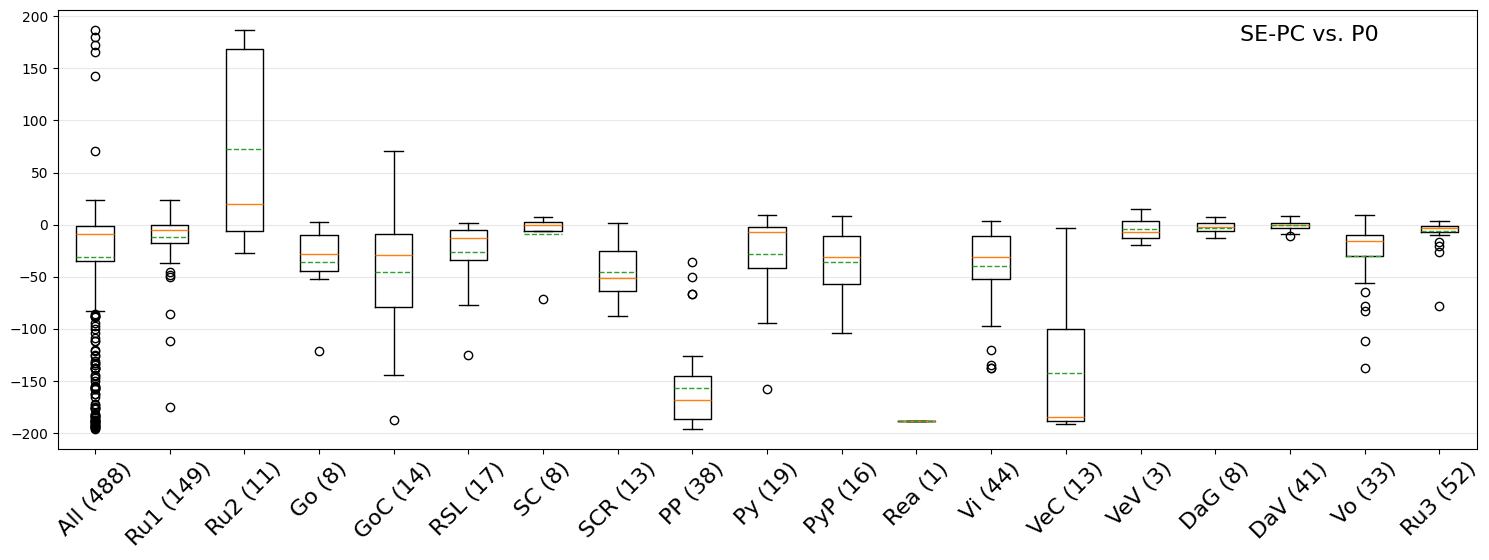

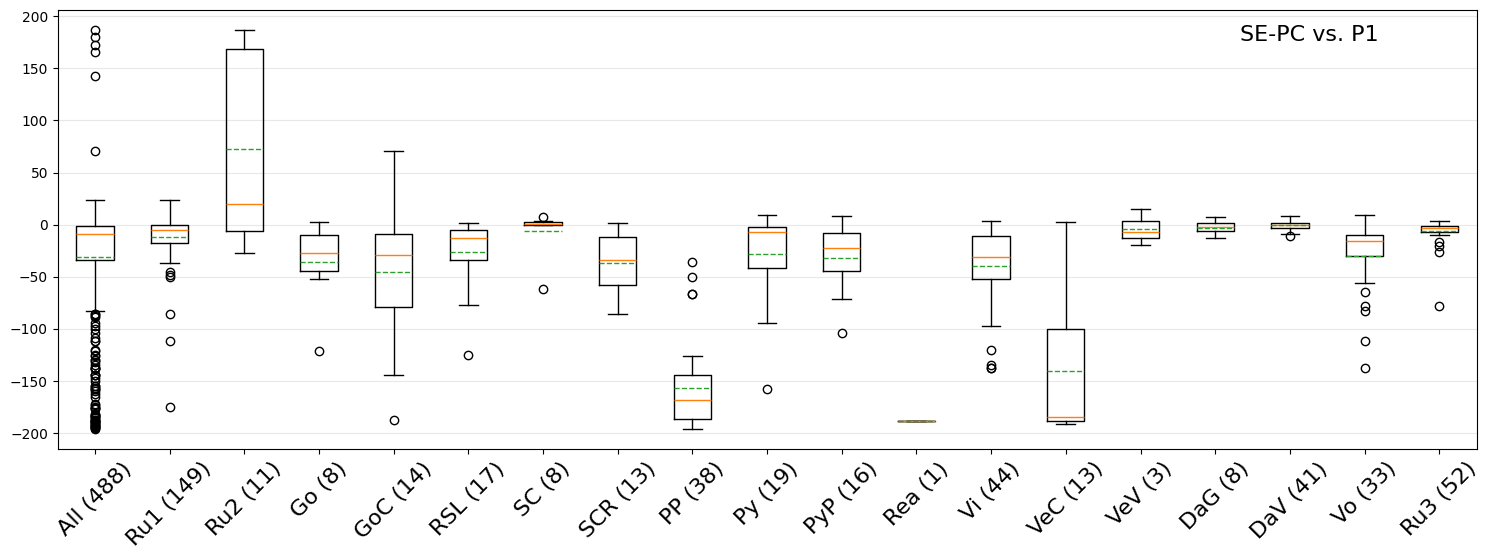

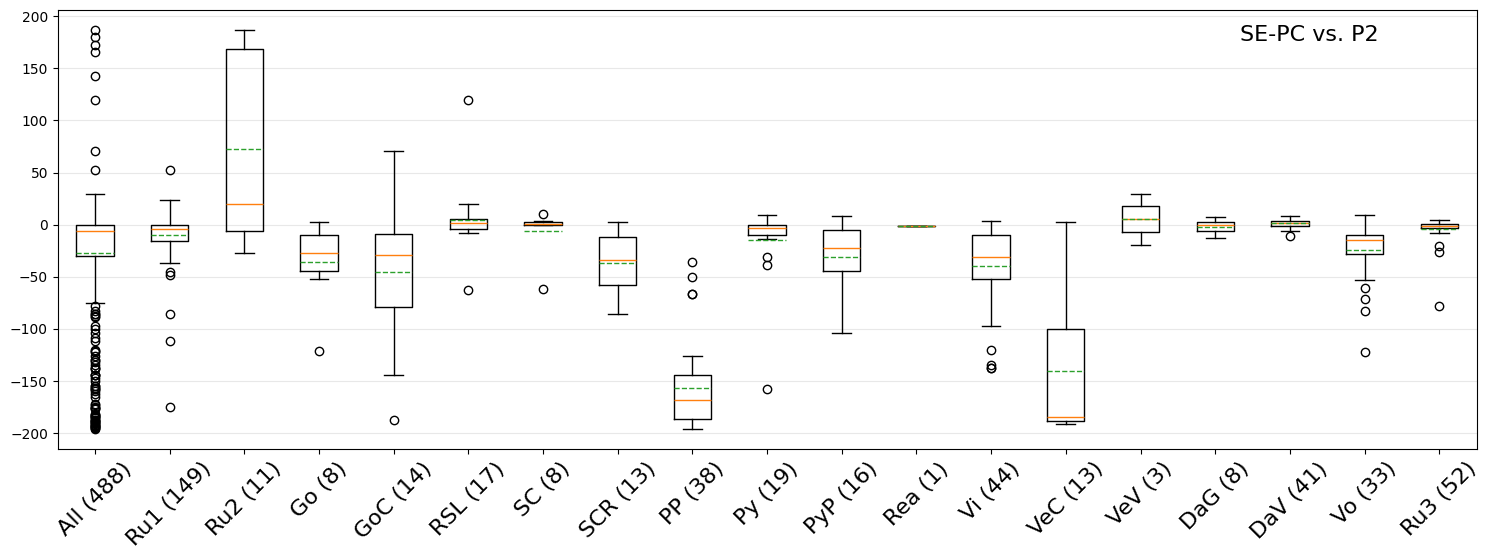

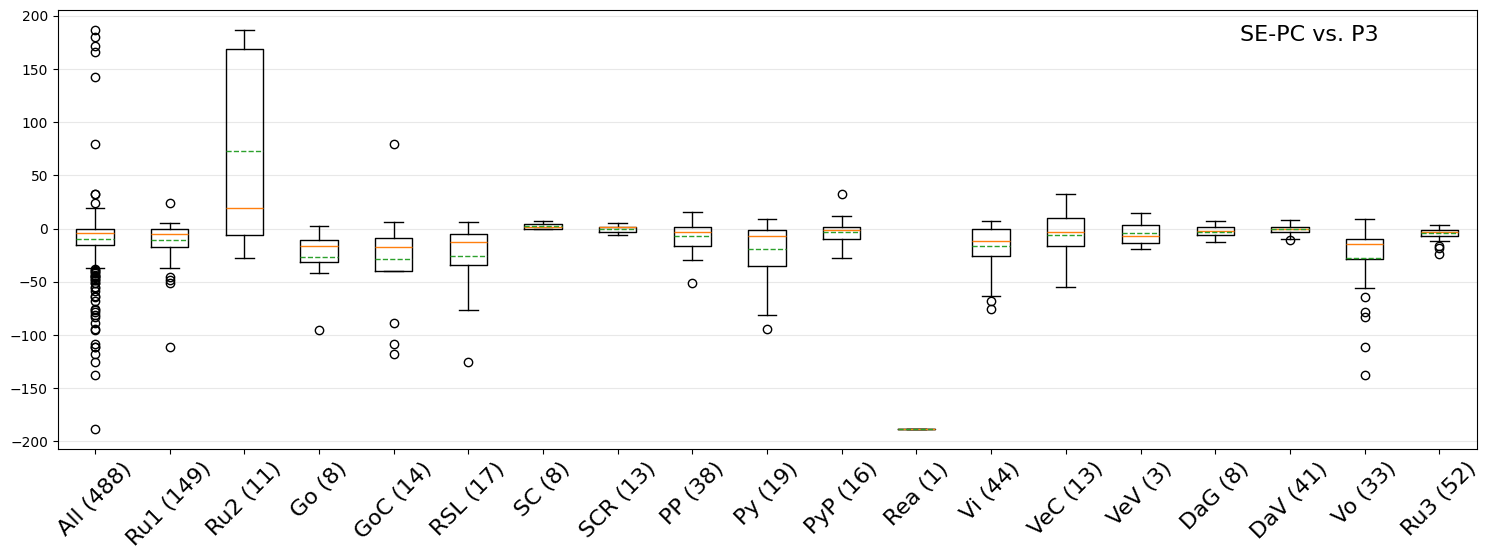

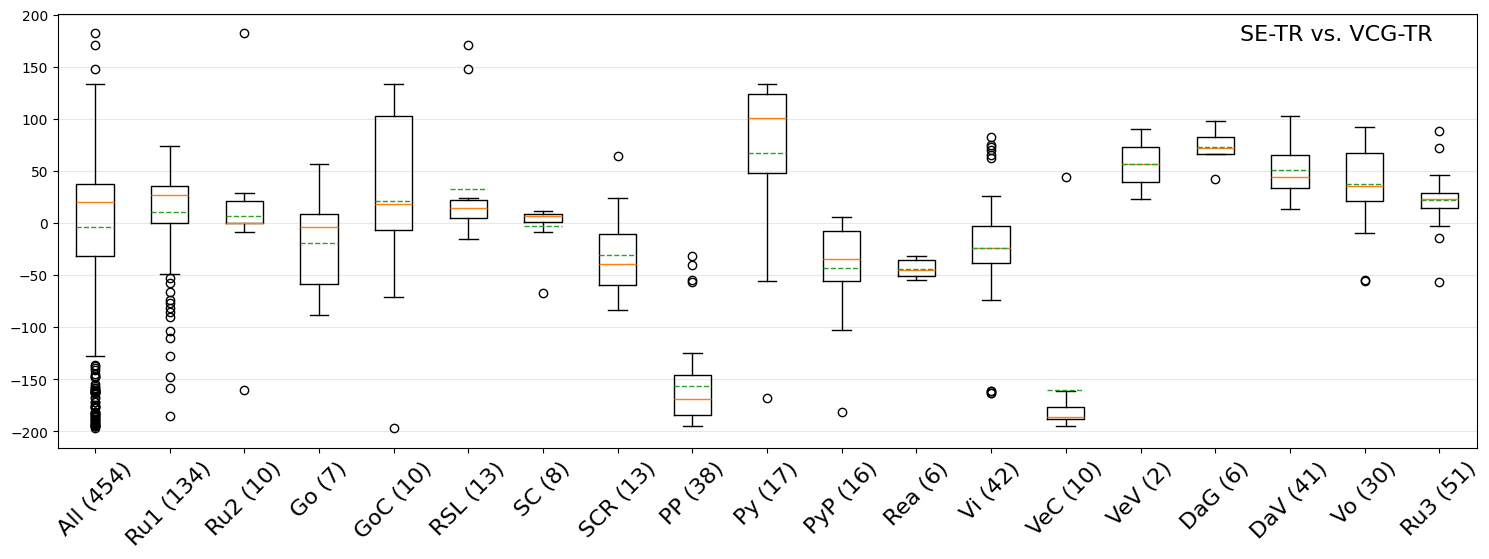

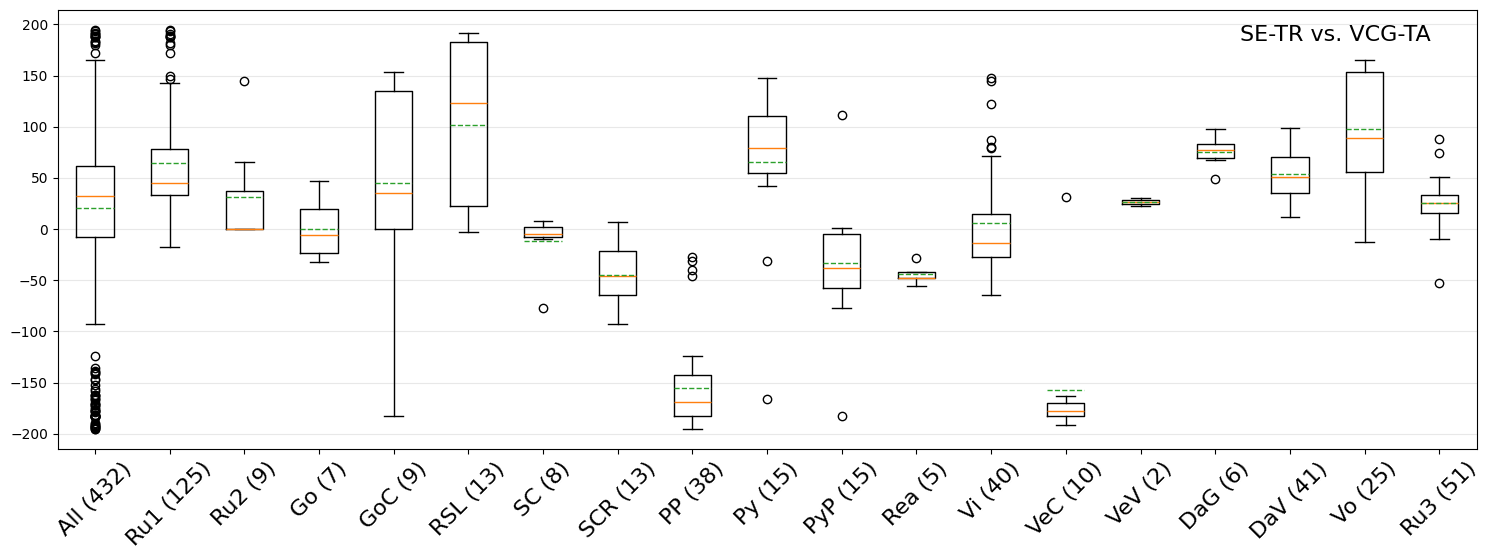

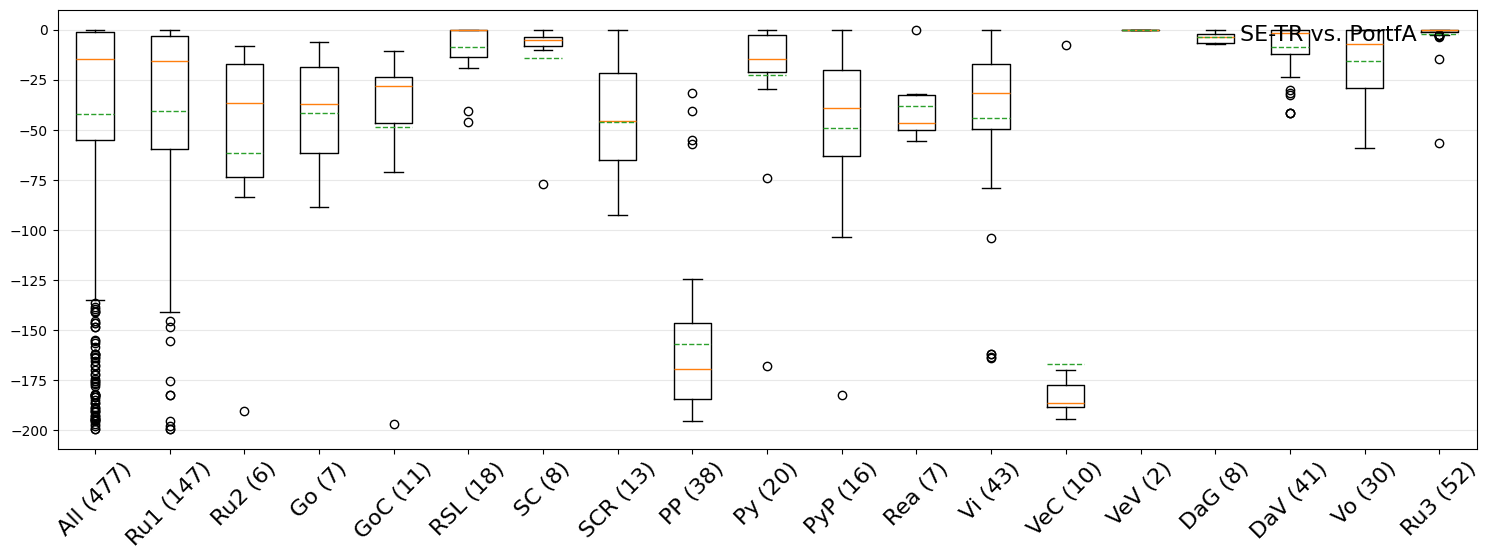

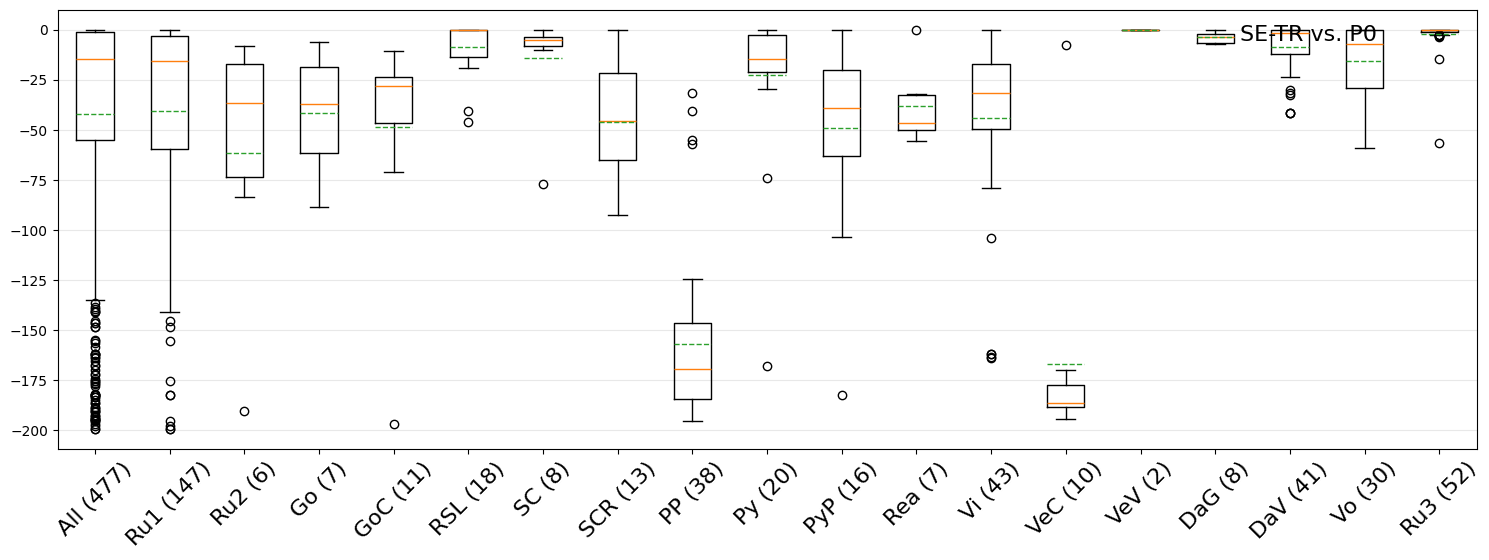

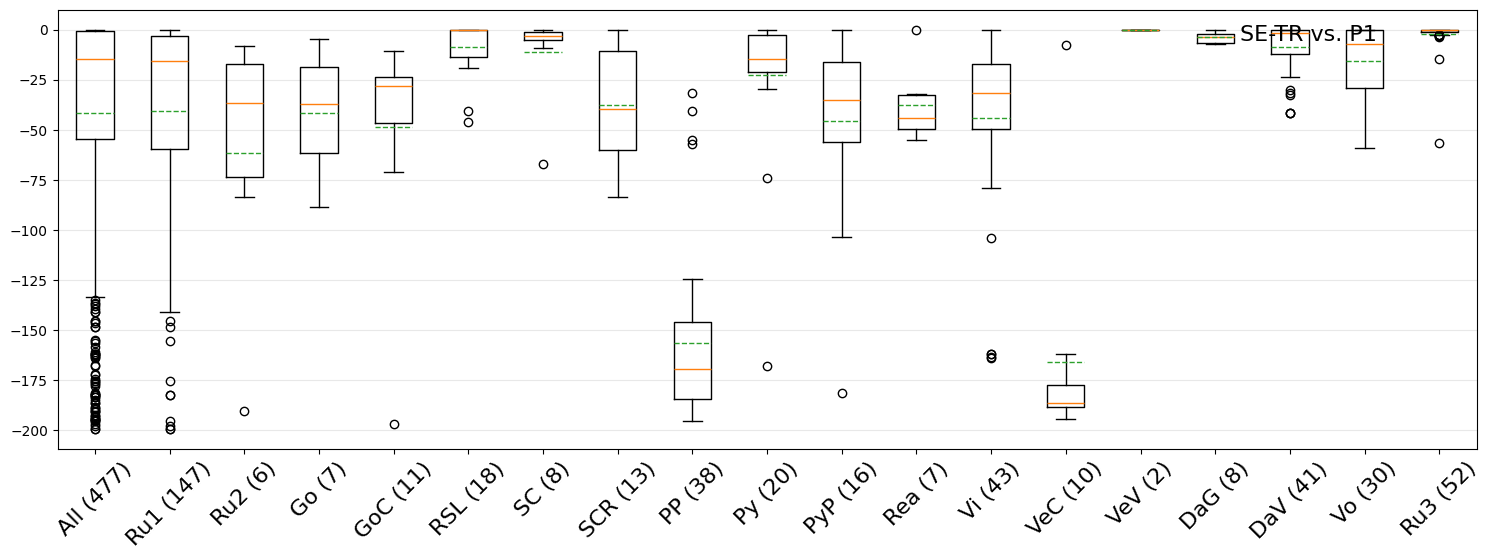

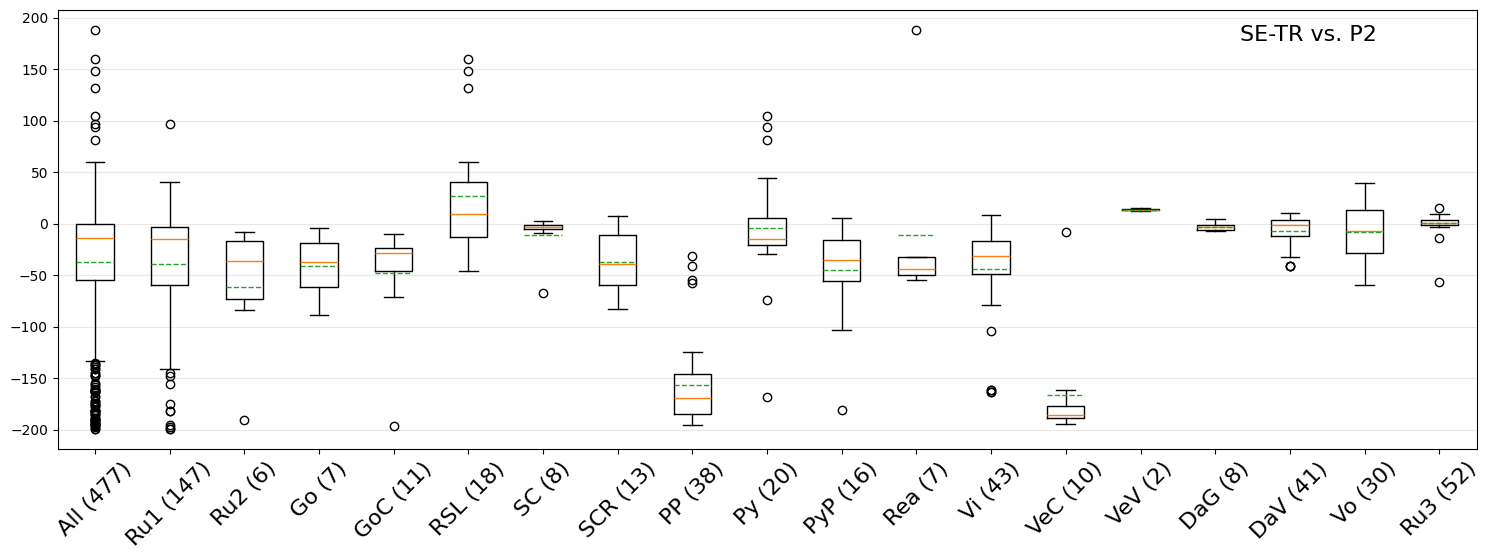

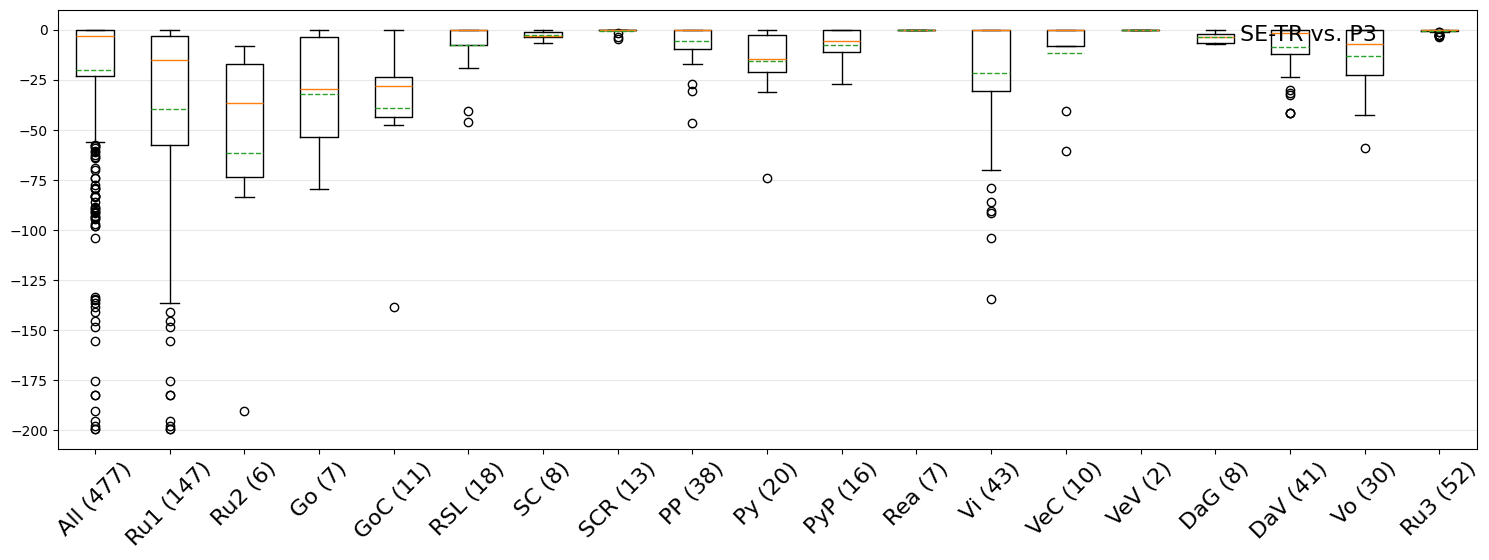

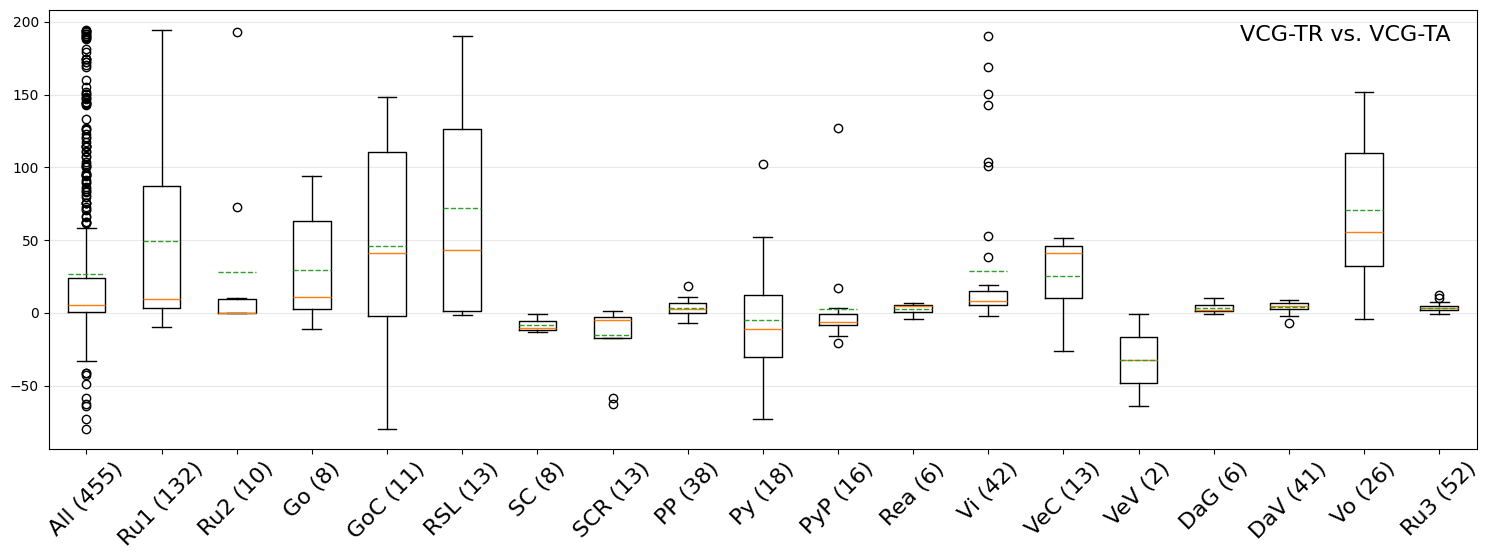

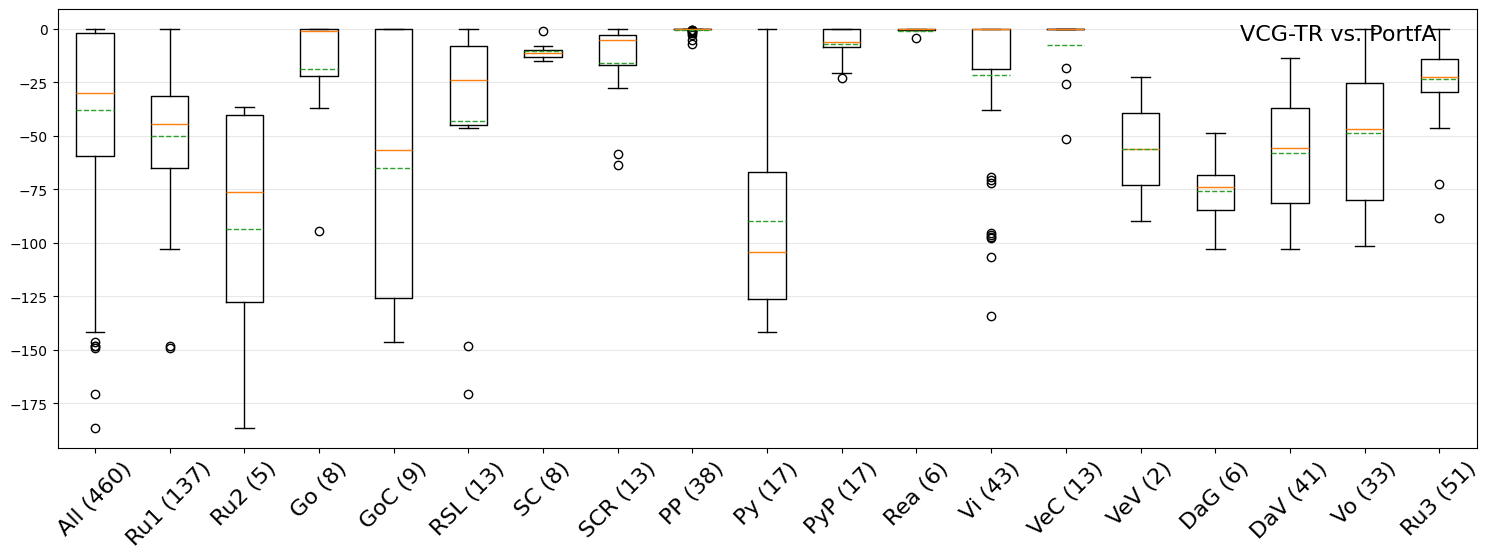

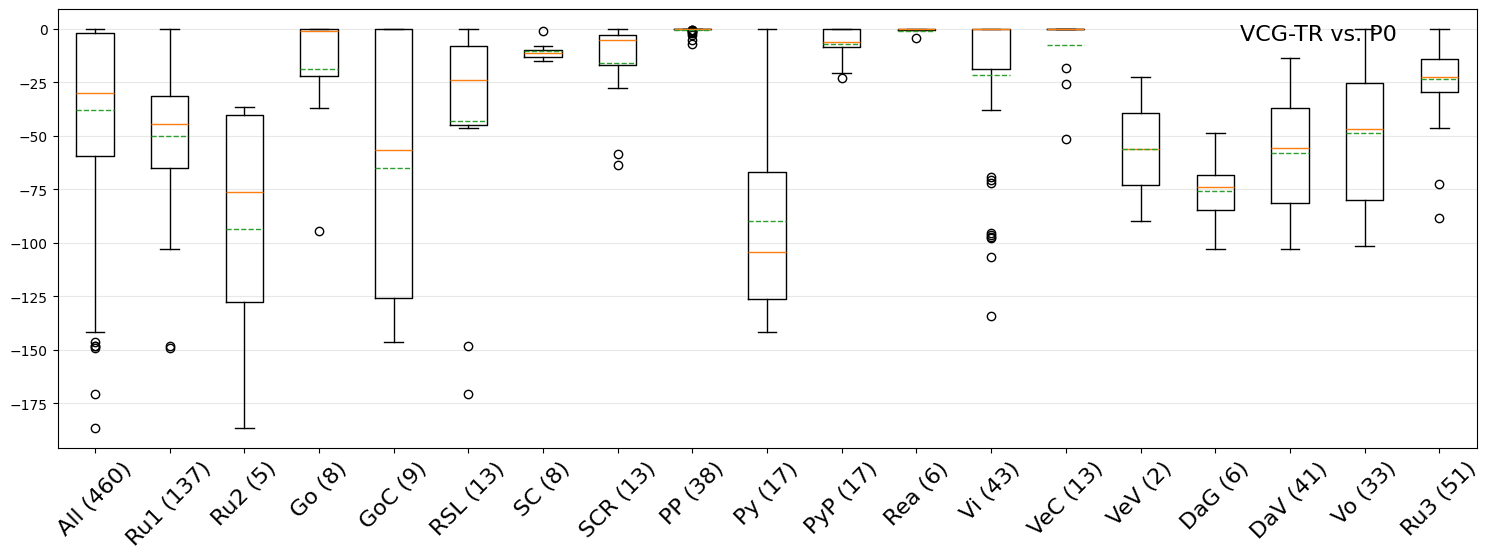

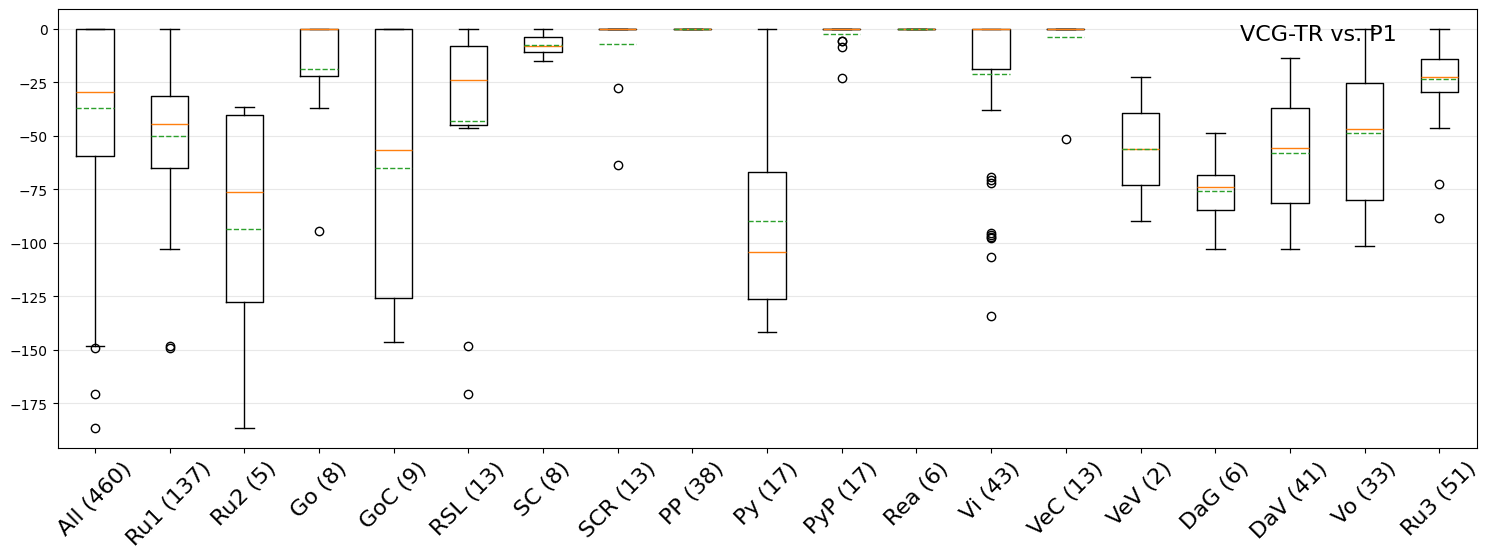

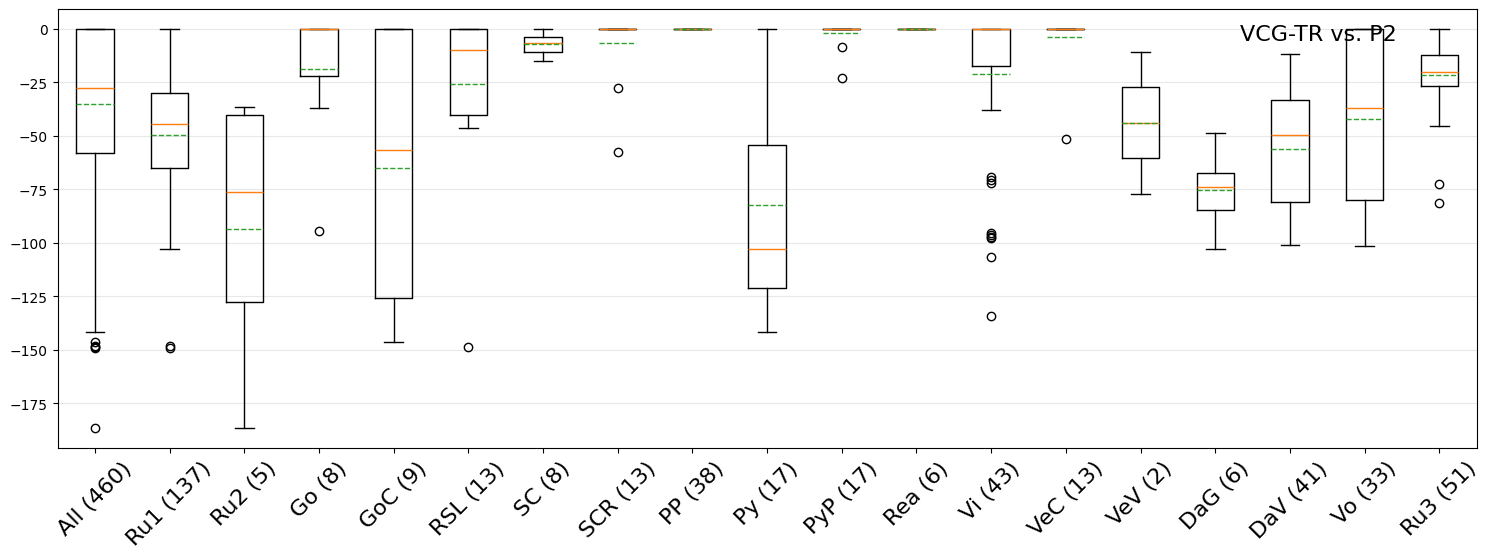

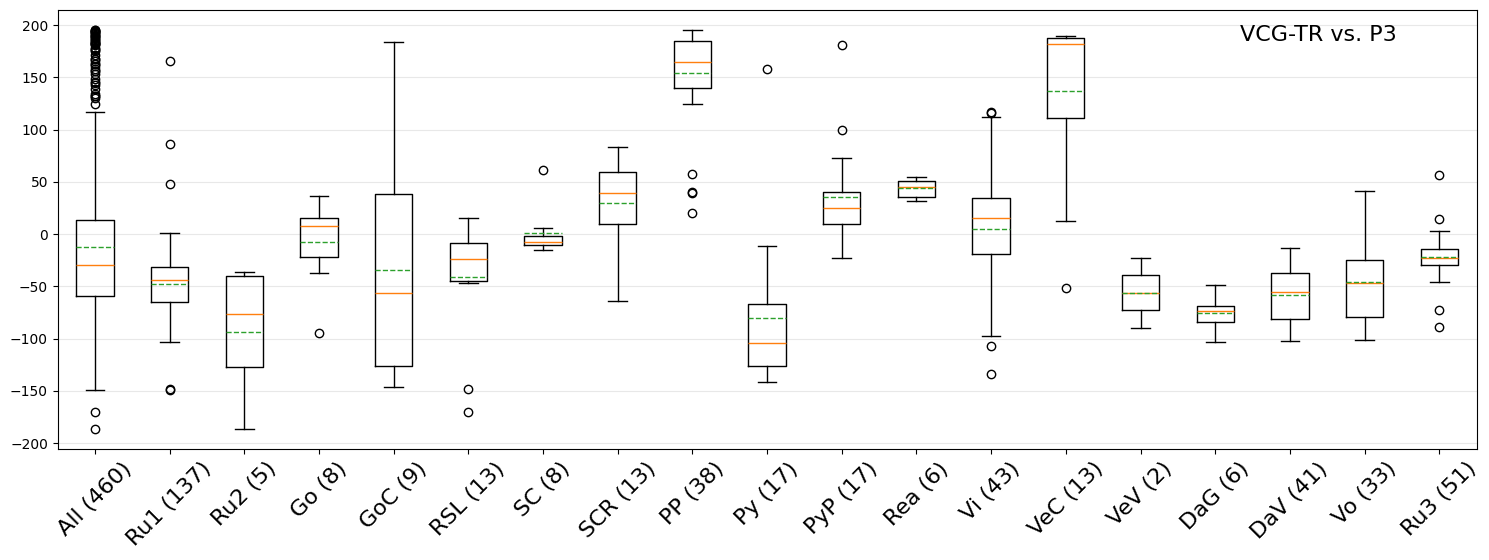

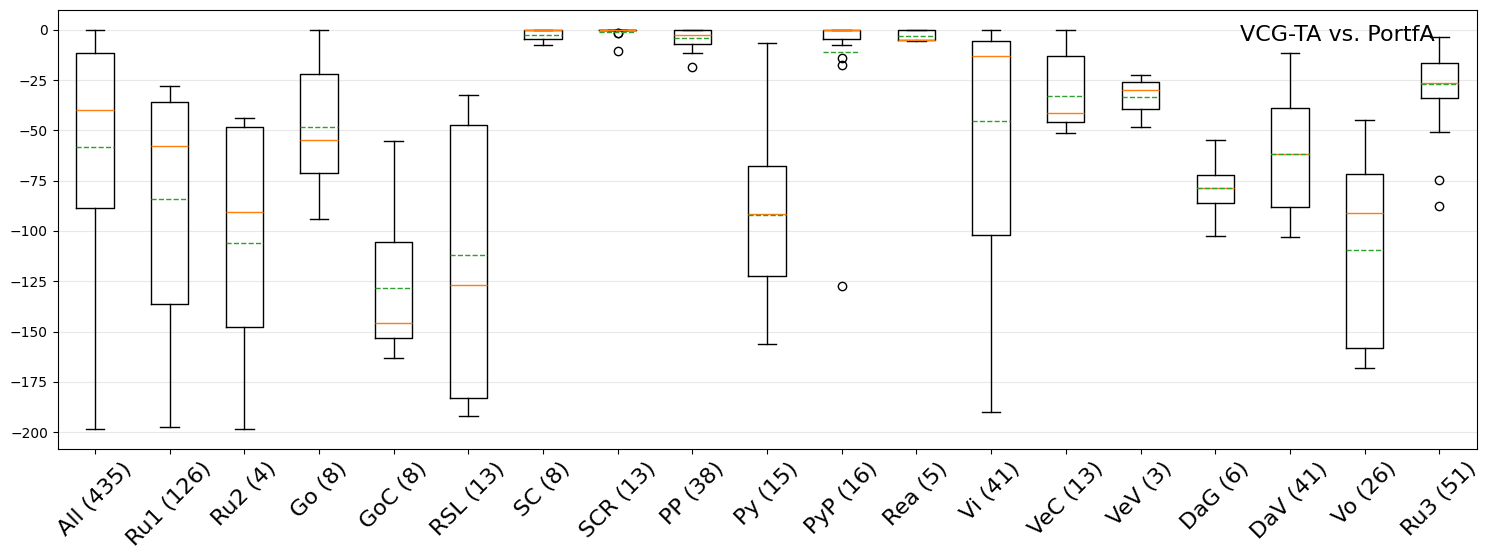

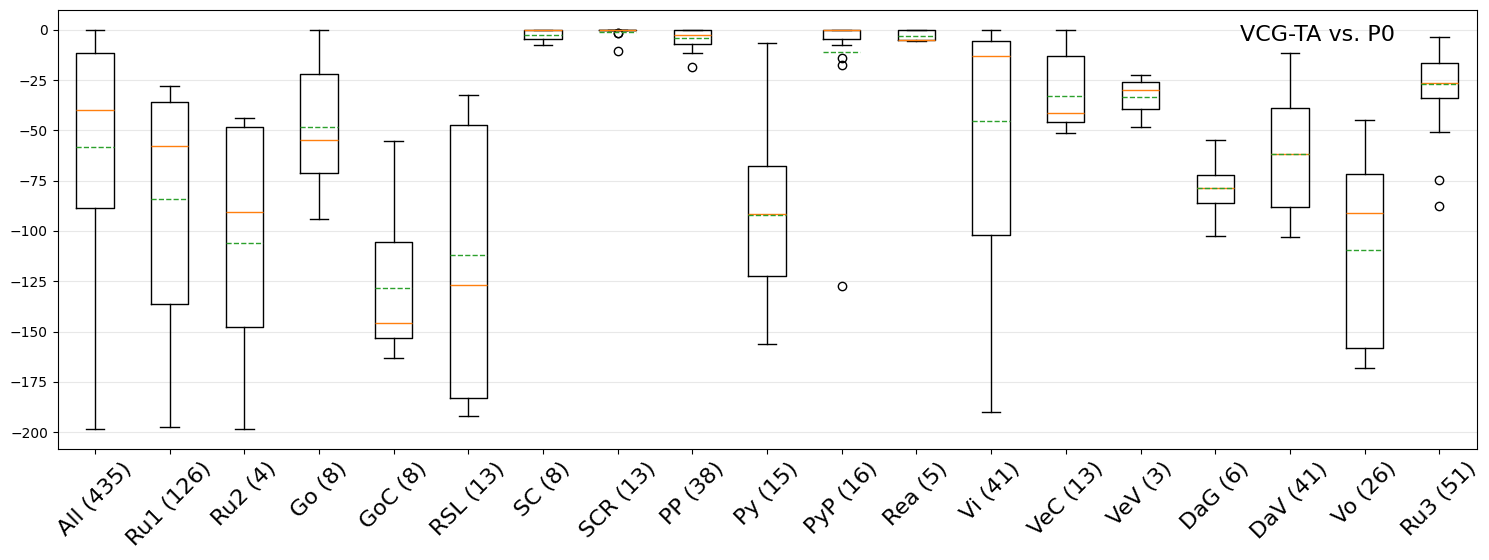

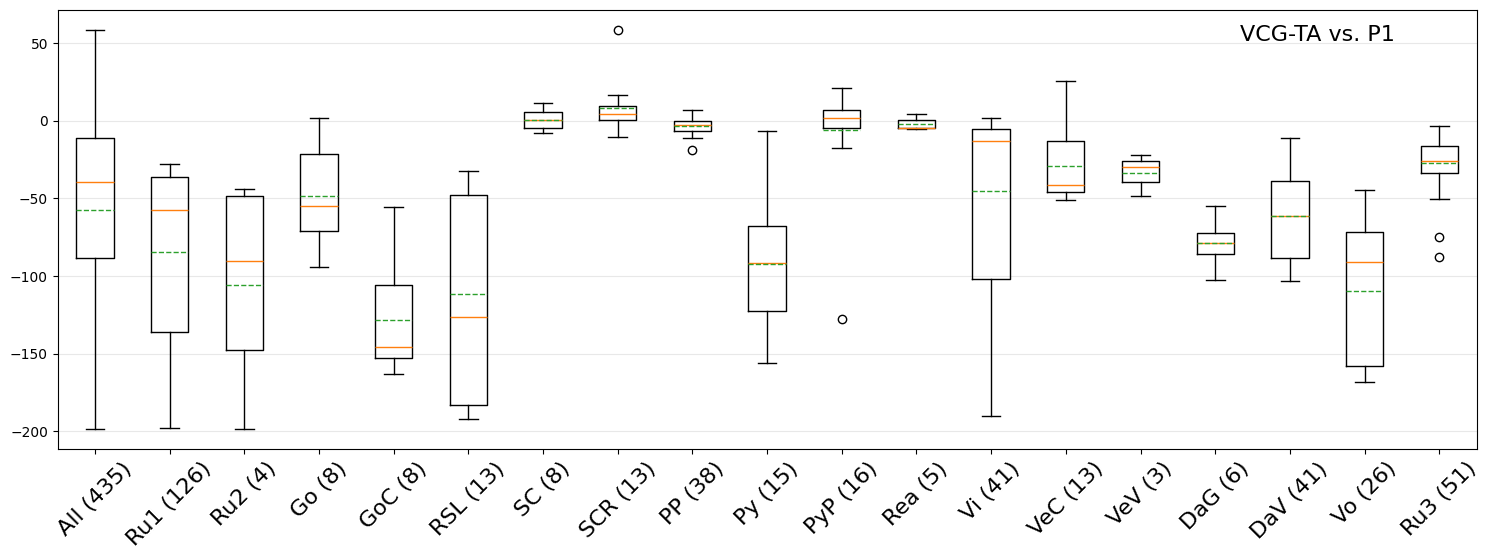

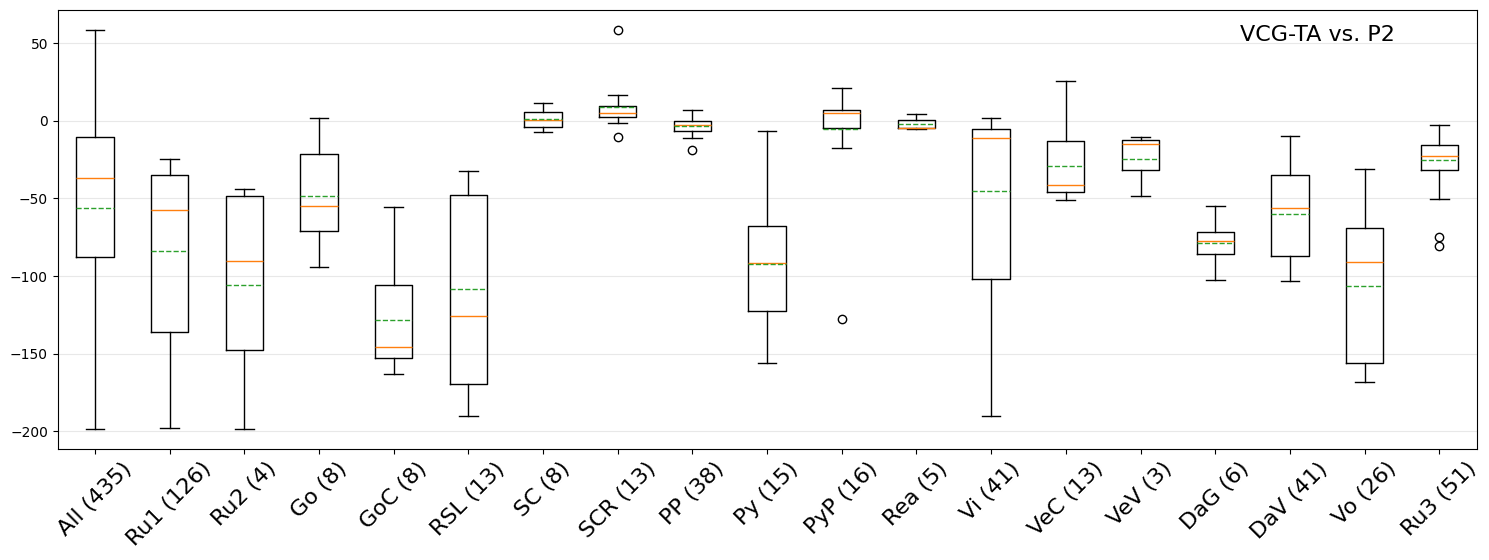

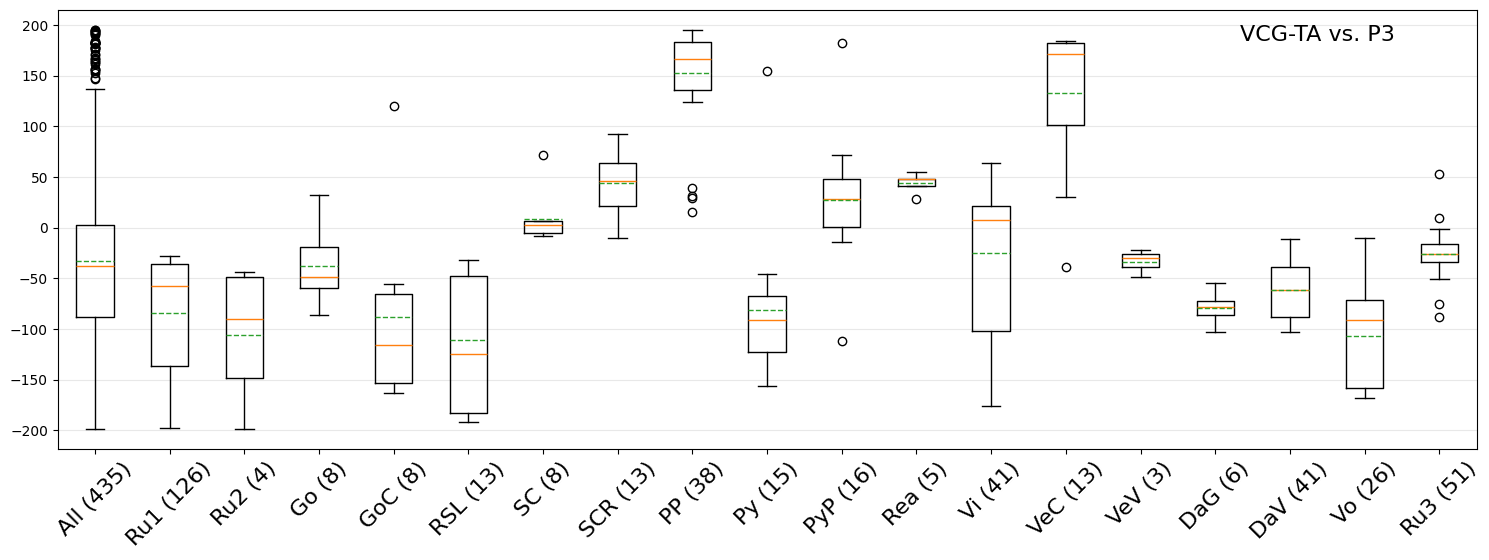

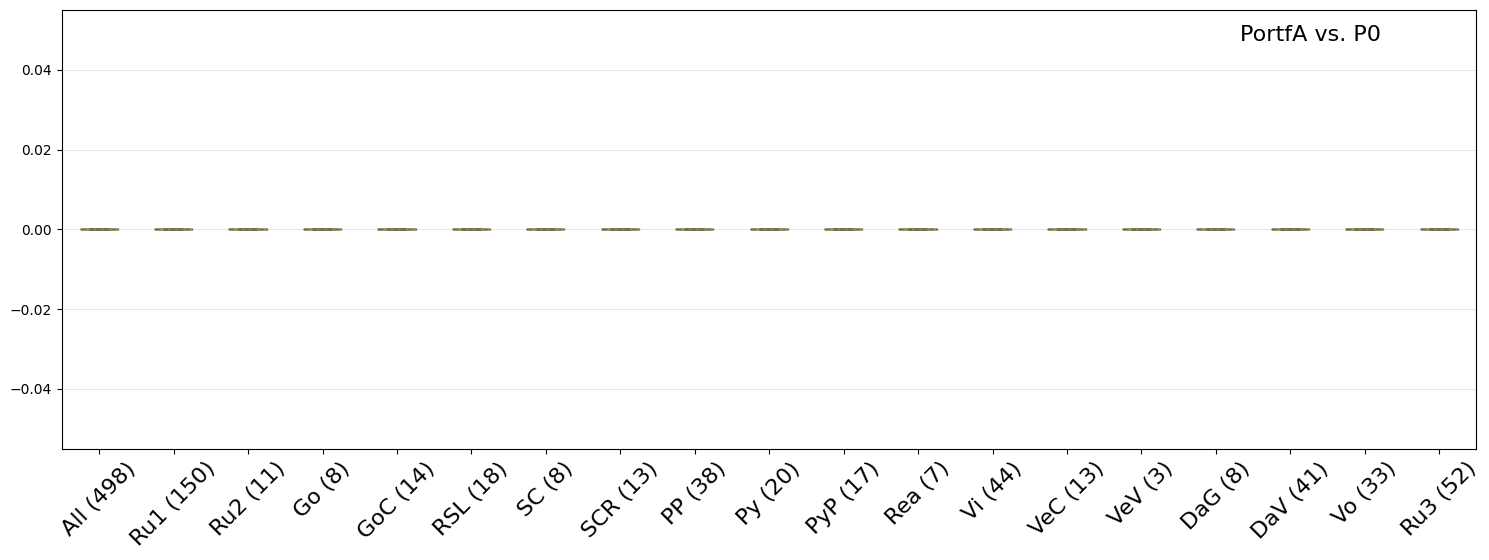

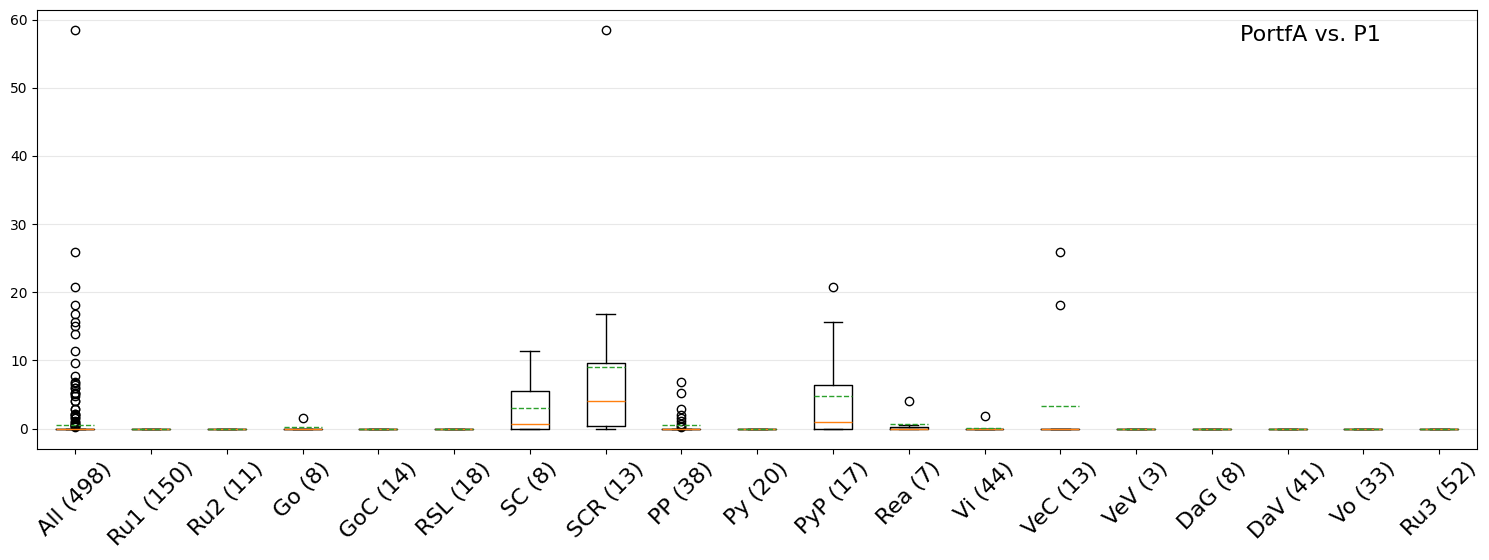

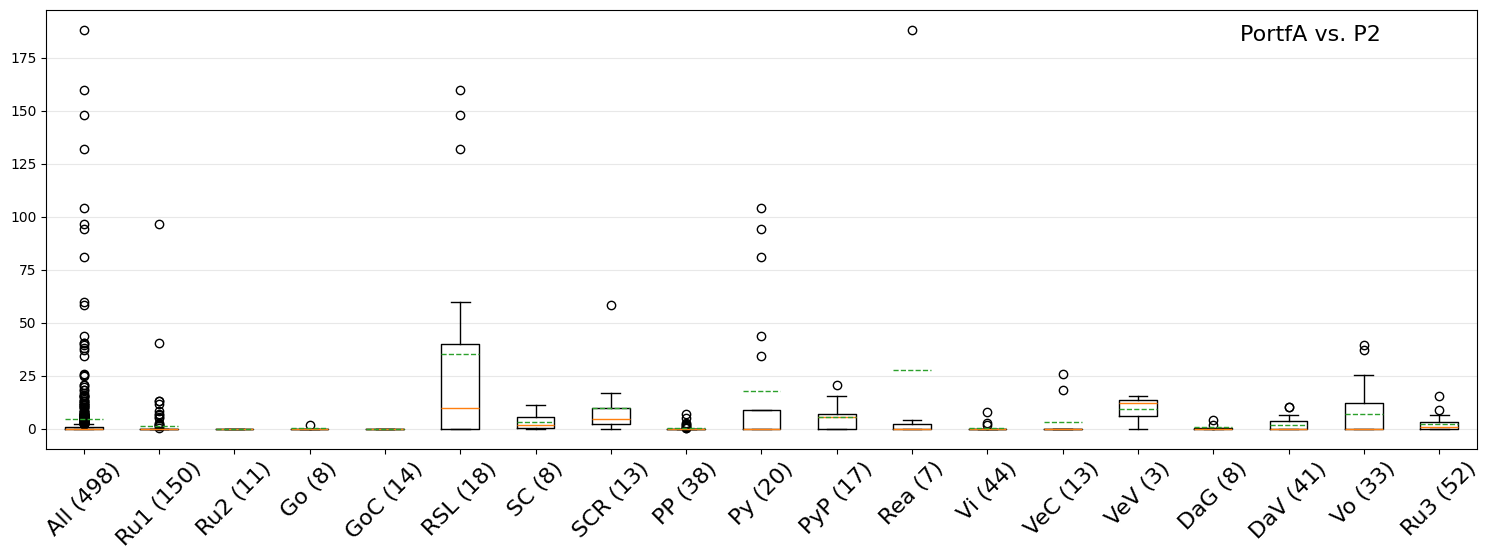

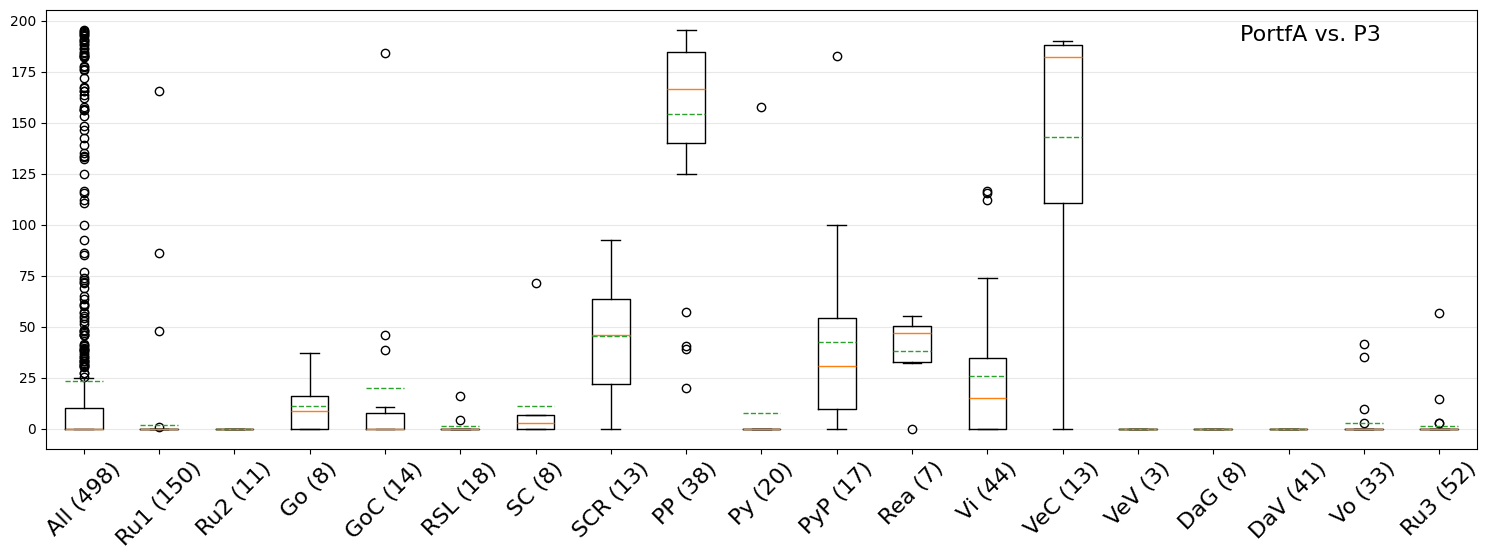

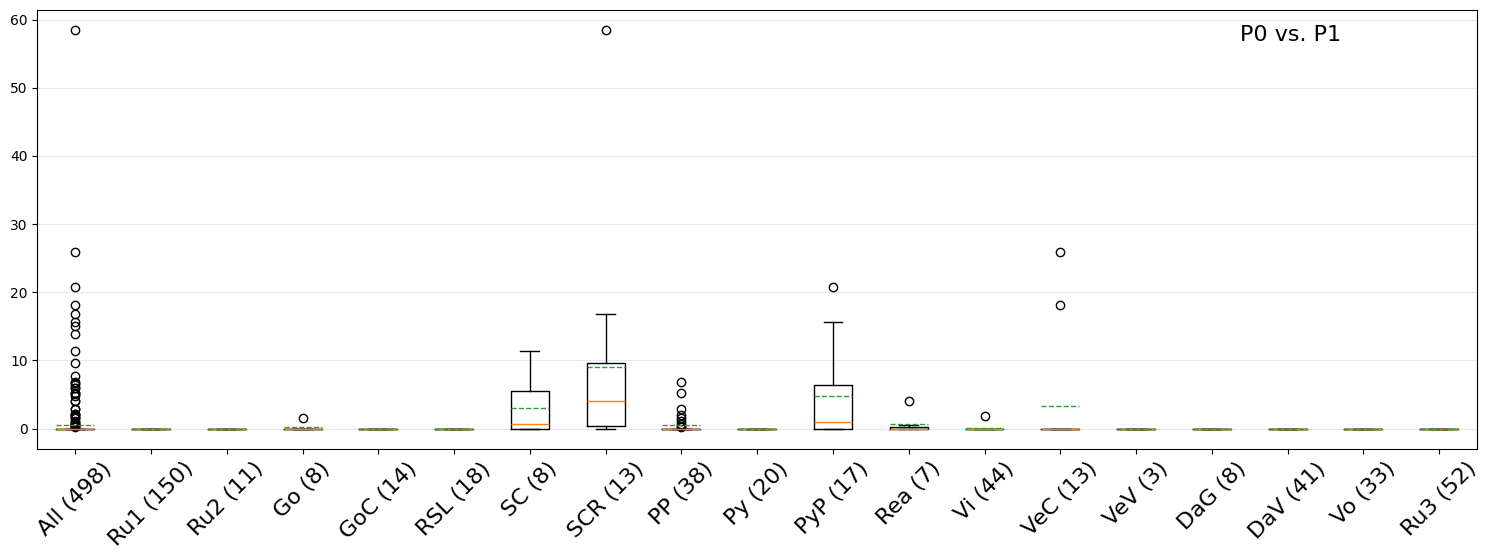

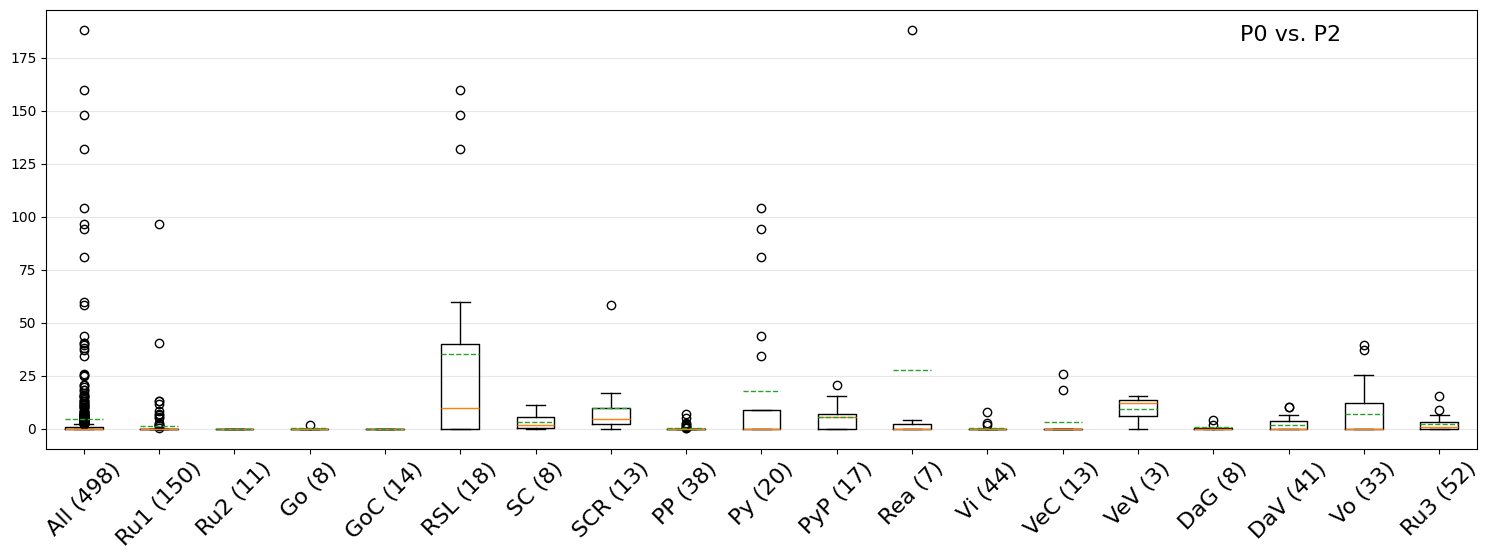

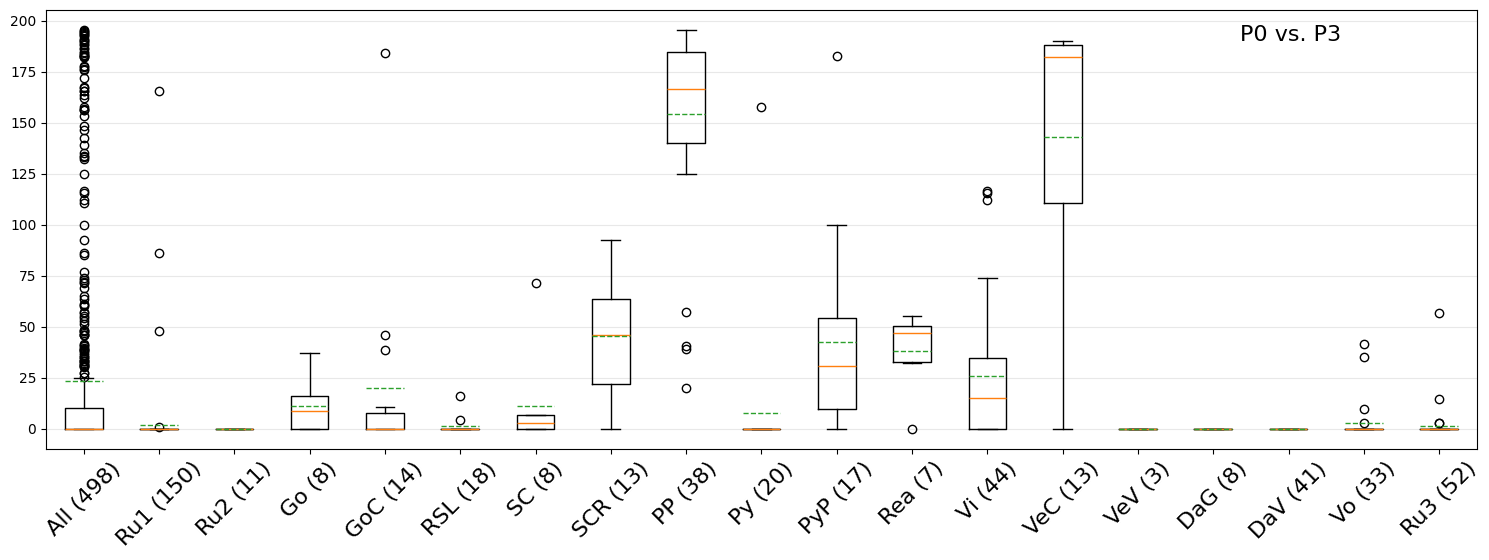

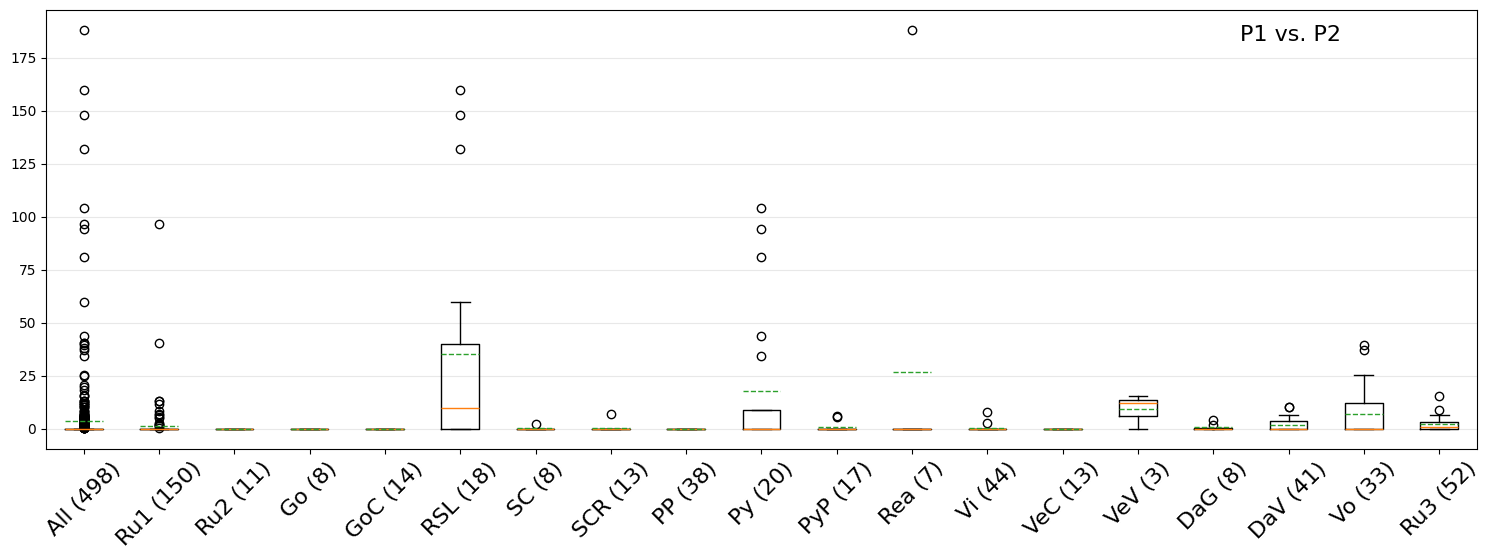

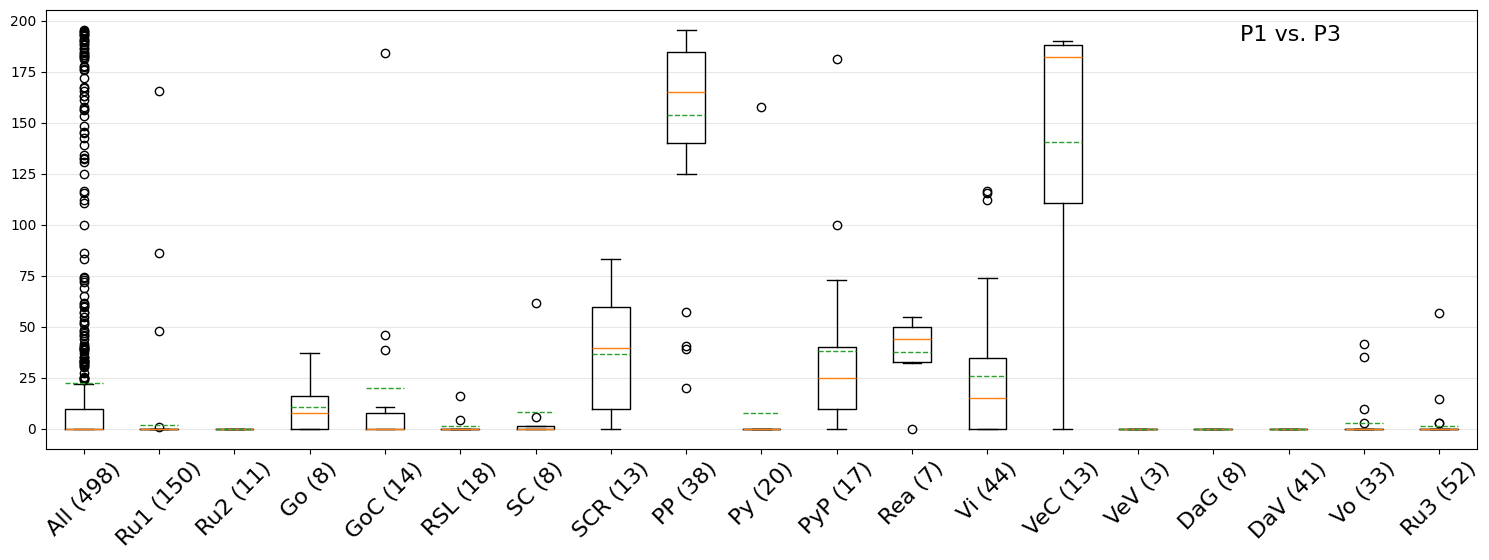

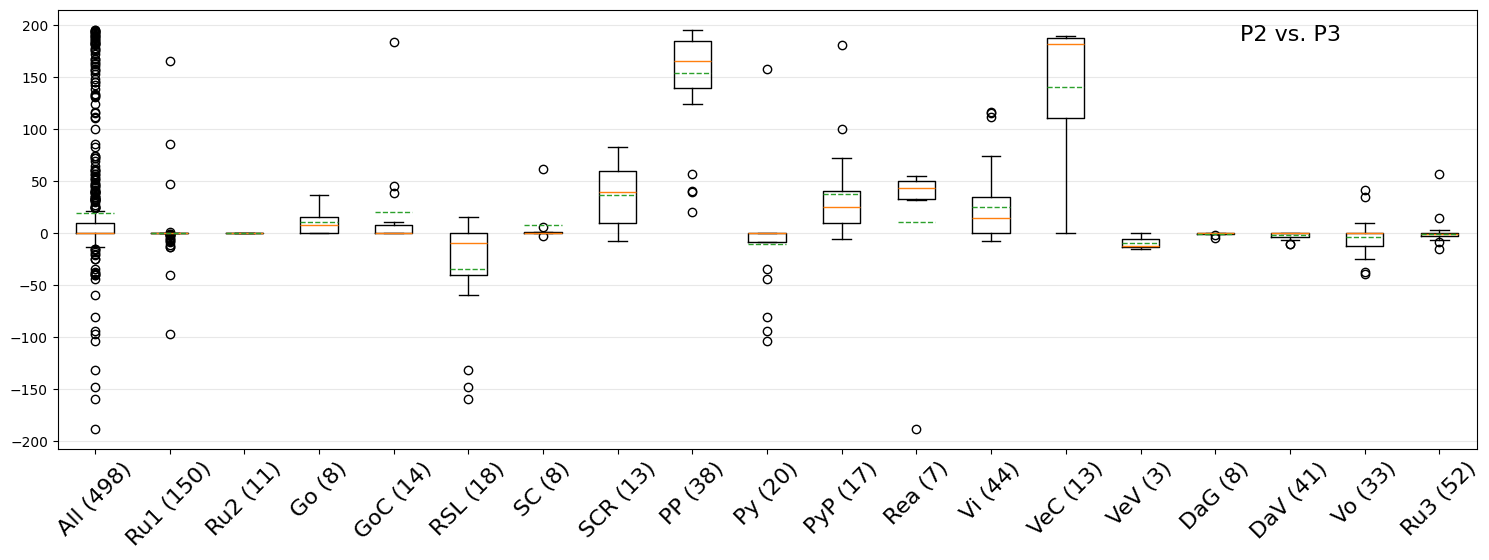

In [29]:
if True: ## Can be disabled to avoid spending time on generating these plots
  _figsize = (15, 5.7) # width, height; in inches
  _filetype = 'pdf' # svg, png
  # _median_color = '#ff8c00'
  # _mean_color = '#006400'
  # _stddev_color = '#008b8b'
  # _mad_color = '#800080'

  _dimension = 'MeanRPD'

  for [verifier1, verifier2] in itertools.combinations(verifiers, 2):
    verifier_pair = f'{verifier1}->{verifier2}'
    column_header = f'{_dimension}:{verifier_pair}'
    print(column_header)

    comparison_values = []
    medians = []
    means = []
    standard_deviations = []
    median_absolute_deviations = []
    
    for group_name in example_groups_dfs:
      print(group_name, end=' ')
      group_df = example_groups_dfs[group_name]
      # print(group_df.shape[0])

      try:
        # Preserve rows where both verifiers reported consistent results
        group_df = group_df[group_df[f'Consistent:{verifier1}'] == True]
        group_df = group_df[group_df[f'Consistent:{verifier2}'] == True]

        # Preserve rows where the two verifiers agree on their verification results
        group_df = group_df[group_df[f'Result:{verifier1}'] == group_df[f'Result:{verifier2}']]

        # Preserve rows where the two verifiers report an actual number
        group_df = group_df[group_df[f'Mean:{verifier1}'].apply(lambda cell: isinstance(cell, numbers.Number))]
        group_df = group_df[group_df[f'Mean:{verifier2}'].apply(lambda cell: isinstance(cell, numbers.Number))]
      except KeyError: # No common entries between `verifier1` and `verifier2`
        # print(group_df.shape[0])
        comparison_values.append([]) # NOTE: Any empty entry breaks the logging code below

        medians.append(0)
        means.append(0)
        standard_deviations.append(0)
        median_absolute_deviations.append(0)
        
        continue

      values = group_df[column_header] # Relevant values, e.g. MeanRPD:V1->V2
      # print(len(values))
      comparison_values.append(values)

      medians.append(values.median())
      means.append(values.mean())
      standard_deviations.append(values.std()) # Standard deviation with ddof = 1 (delta degrees of freedom)
      median_absolute_deviations.append(values.apply(scipy.stats.median_abs_deviation, by_row=False)) # See https://en.wikipedia.org/wiki/Median_absolute_deviation

    print()

    try:
      ## Commented to avoid to_excel raising an error if a group is empty
      # logging_df = pd.DataFrame()
      # for idx, group_name in enumerate(example_groups_dfs):
      #  logging_df[group_name] = comparison_values[idx]
      # logging_df_file_name = f'{excels_logging}/{sanitize_file_name(column_header)}---comparison_values.xlsx'
      # to_excel(logging_df, logging_df_file_name)

      fig, ax = plt.subplots(tight_layout=True, figsize=_figsize)
      ax.boxplot(comparison_values, notch=False, showmeans=True, meanline=True) # Notches?
      ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)

      ax.set(
        axisbelow=True, # Hide the grid behind plot objects
        # title=column_header + "\n\n\n\n", # Newlines to gain extra margin space above the plot
        # xlabel='Group',
        # ylabel='RPD',
      )

      xticklabels = [f'{group_name} ({len(comparison_values[idx])})' for idx, group_name in enumerate(example_groups_dfs)]
      ax.set_xticklabels(xticklabels, rotation=45, fontsize=16)

      fig.text(0.83, 0.92, f'{verifier1} vs. {verifier2}', size=16)

      # fig.text(0.90, 0.50, f'Mean', color=_mean_color, size='small')
      # fig.text(0.80, 0.50, f'StdDev', color=_stddev_color, size='small')
      # fig.text(0.80, 0.01, f'MAD', color=_mad_color, size='small')  
      # fig.text(0.70, 0.01, f'Whiskers: 1.5 IQR', color='black', size='small')

      for idx, xpos in enumerate(np.arange(len(example_groups_dfs)) + 1):
        median = str(round(medians[idx], 2))
        mean = str(round(means[idx], 2))
        stddev = str(round(standard_deviations[idx], 2))
        mad = str(round(median_absolute_deviations[idx], 2))
        
        # if idx == 0:
        #   median = "MD=" + median
        #   mean = "MN=" + mean
        #   stddev = "SD=" + stddev
        #   mad = "MAD=" + mad

        horizontalalignment = 'center'

        # ax.text(xpos, 1.08, median, transform=ax.get_xaxis_transform(), horizontalalignment=horizontalalignment, color=_median_color, size='small')
        # ax.text(xpos, 1.06, mean, transform=ax.get_xaxis_transform(), horizontalalignment=horizontalalignment, color=_mean_color, size='small')
        # ax.text(xpos, 1.04, stddev, transform=ax.get_xaxis_transform(), horizontalalignment=horizontalalignment, color=_stddev_color, size='small')
        # ax.text(xpos, 1.02, mad, transform=ax.get_xaxis_transform(), horizontalalignment=horizontalalignment, color=_mad_color, size='small')

      image_file_name = f'{boxplots_directory}/{sanitize_file_name(column_header)}.{_filetype}'
      print(image_file_name)
      fig.savefig(image_file_name)
    except Exception as ex:
      print(f'Failed to generate plot for {column_header}')
      print(ex)